# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from matplotlib import rcParams

from sklearn.ensemble import  RandomForestRegressor, IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [3]:
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [5]:
from keras.models import Sequential
from keras.layers import Dense

# Some preprocessing

In [6]:
data = pd.read_csv("./collected_data/prepared_data/prestep_data.csv")
data.head()

vertices  redexes  redex_depths  redex_indexes  heights  widths  \
0        53        3             4             12       15      21   
1        50        2             5             27       15      20   
2        27        1             1              1        8      10   
3        54        6             7             10       13      17   
4        51        6            11             16       14      16   

   steps_time strategy_name  
0      131224            LI  
1      187277            LI  
2       32085            LI  
3      179030            LI  
4      179197            LI

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3931 entries, 0 to 3930
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   vertices       3931 non-null   int64 
 1   redexes        3931 non-null   int64 
 2   redex_depths   3931 non-null   int64 
 3   redex_indexes  3931 non-null   int64 
 4   heights        3931 non-null   int64 
 5   widths         3931 non-null   int64 
 6   steps_time     3931 non-null   int64 
 7   strategy_name  3931 non-null   object
dtypes: int64(7), object(1)
memory usage: 245.8+ KB


In [8]:
pca = PCA(2, random_state=42)
data_pca = pca.fit_transform(data[["vertices", "redexes", "redex_depths", "heights", "widths"]])

C:\Users\voldo\AppData\Local\Temp\ipykernel_26520\2351182786.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], palette="deep")


<AxesSubplot: >

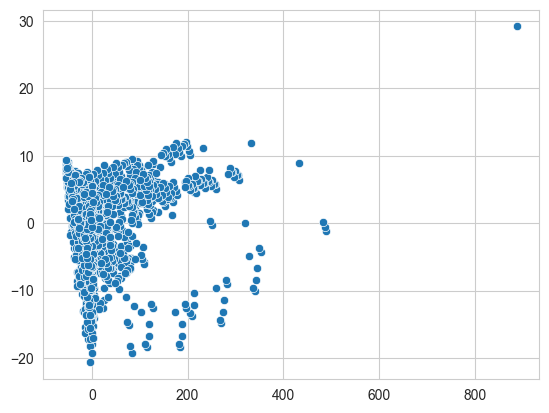

In [9]:
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], palette="deep")

<AxesSubplot: >

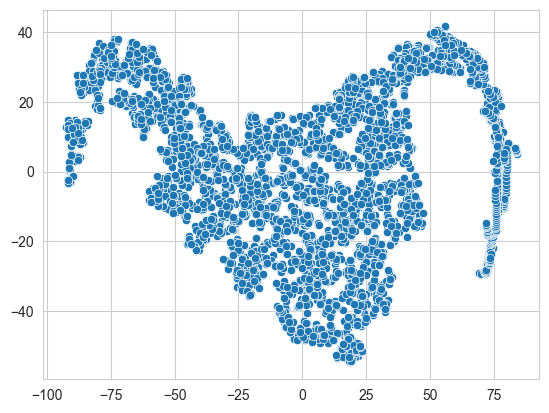

In [10]:
tsne = TSNE(random_state=3)
tsne_feature = tsne.fit_transform(data[["vertices", "redexes", "redex_depths", "heights", "widths"]])
sns.scatterplot(x=tsne_feature[:, 0], y=tsne_feature[:, 1])

## Check skewed features

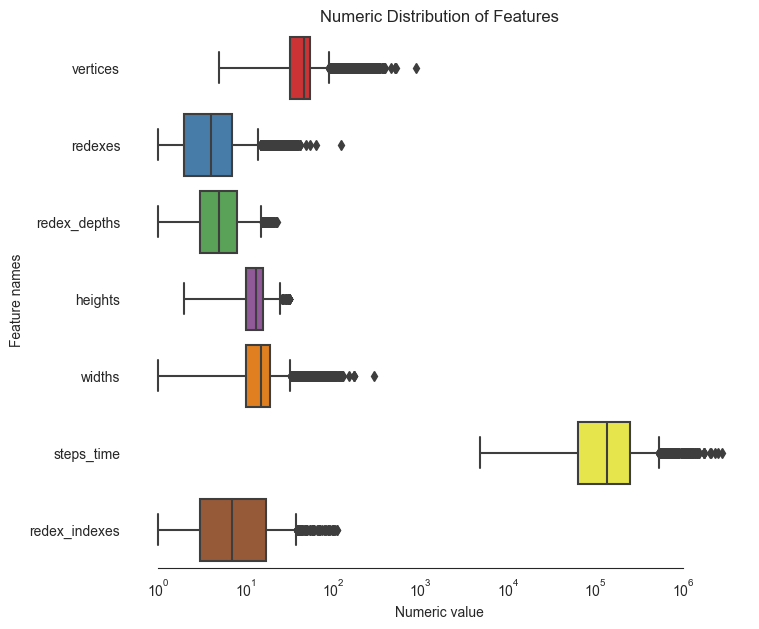

In [11]:
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=data[["vertices", "redexes", "redex_depths", "heights", "widths", "steps_time", "redex_indexes"]], orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric value")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [12]:
# Find skewed numerical features
skew_features = data[["vertices", "redexes", "redex_depths", "heights", "widths", "steps_time", "redex_indexes"]].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print(f"There are {high_skew.shape[0]} numerical features with skew > 0.5: ")
skewness = pd.DataFrame({"skew": skew_features})
skewness.head(10)

There are 6 numerical features with skew > 0.5: 


skew
vertices       4.235690
widths         4.148381
redexes        3.953192
steps_time     3.692667
redex_indexes  2.305134
redex_depths   1.034103
heights        0.428418

array([[<AxesSubplot: title={'center': 'vertices'}>,
        <AxesSubplot: title={'center': 'redexes'}>,
        <AxesSubplot: title={'center': 'redex_depths'}>],
       [<AxesSubplot: title={'center': 'redex_indexes'}>,
        <AxesSubplot: title={'center': 'heights'}>,
        <AxesSubplot: title={'center': 'widths'}>],
       [<AxesSubplot: title={'center': 'steps_time'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

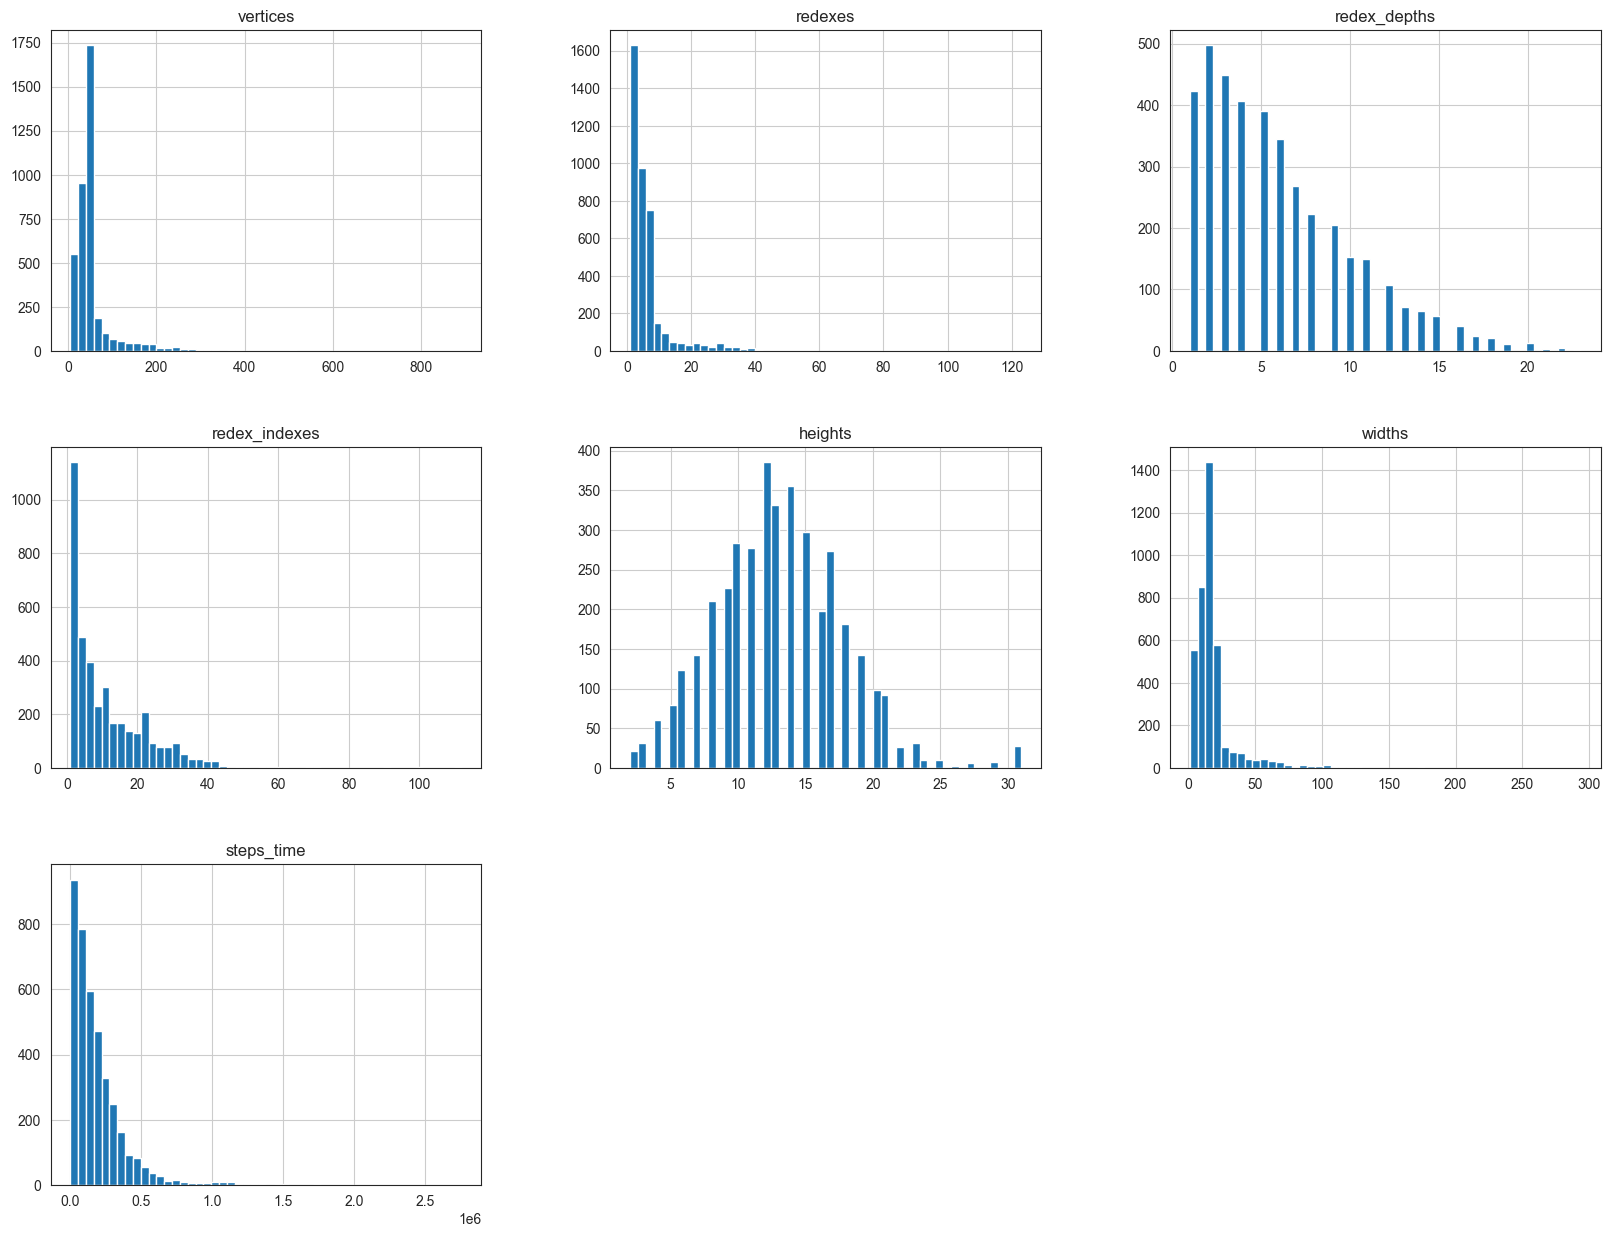

In [13]:
rcParams['figure.figsize'] = 20, 15
data.hist(bins=50)

array([[<AxesSubplot: title={'center': 'vertices'}>,
        <AxesSubplot: title={'center': 'redexes'}>],
       [<AxesSubplot: title={'center': 'redex_depths'}>,
        <AxesSubplot: title={'center': 'heights'}>],
       [<AxesSubplot: title={'center': 'widths'}>,
        <AxesSubplot: title={'center': 'steps_time'}>]], dtype=object)

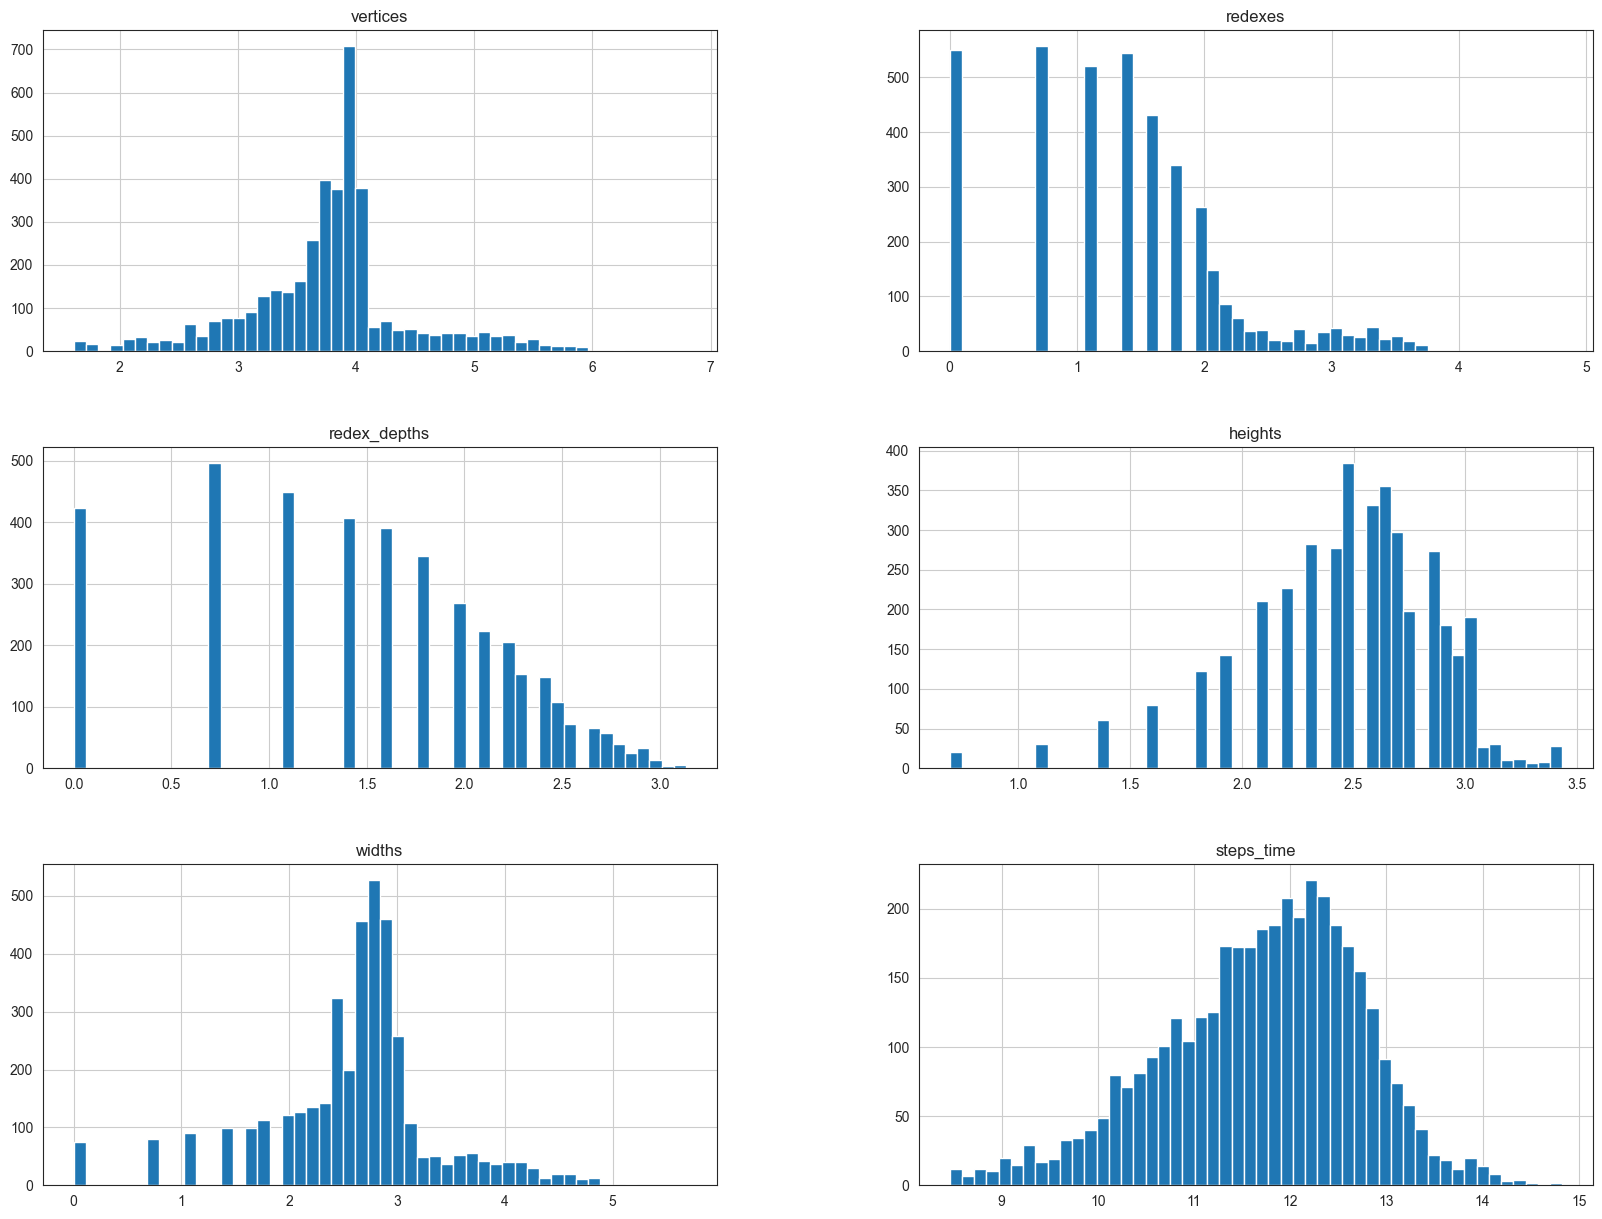

In [14]:
data_log = pd.DataFrame()
for col_name in ["vertices", "redexes", "redex_depths", "heights", "widths", "steps_time"]:
    data_log[col_name] = np.log(data[col_name])

data_log.hist(bins=50)

In [15]:
data_for_training = pd.DataFrame()

data_for_training["vertices"] = data_log["vertices"]
data_for_training["redexes"] = data_log["redexes"]
data_for_training["redex_depths"] = data_log["redex_depths"]
data_for_training["heights"] = data["heights"]
data_for_training["widths"] = data_log["widths"]
data_for_training["steps_time"] = data_log["steps_time"]

In [16]:
def split_dataset(dataset, test_ratio=0.3):
    test_indices_filter = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices_filter], dataset[test_indices_filter]


train_ds, test_ds = split_dataset(data_for_training)
print(f"Examples for training {len(train_ds)}")
print(f"Examples for testing {len(test_ds)}")

Examples for training 2759
Examples for testing 1172


In [17]:
x_train, y_train = train_ds[["vertices", "redexes", "redex_depths", "heights", "widths"]], train_ds[["steps_time"]]
x_test, y_test = test_ds[["vertices", "redexes", "redex_depths", "heights", "widths"]], test_ds[["steps_time"]]

In [18]:
x_data, y_data = data_for_training[["vertices", "redexes", "redex_depths", "heights", "widths"]], data_for_training[["steps_time"]]

# Functions for drawing predicted values

In [19]:
rcParams['figure.figsize'] = 10, 12

def draw_pred_lines(y_pred, y_real):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    for key_, val_ in drawing_df.items():
        plt.plot(range(len(val_)), val_, label=key_)

    plt.xlabel("No")
    plt.ylabel("Step Time")
    plt.title("Pred vs Real Step Time")
    plt.legend()
    plt.show()

# 1. Linear Regression

In [20]:
lin_regressor = LinearRegression()
lin_regressor.fit(x_train, y_train)

y_train_pred = lin_regressor.predict(x_train)
y_test_pred = lin_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)

TRAIN Root Mean Squared Error(RMSE): 0.2916478153962388
TEST Root Mean Squared Error(RMSE): 0.2891117055700104


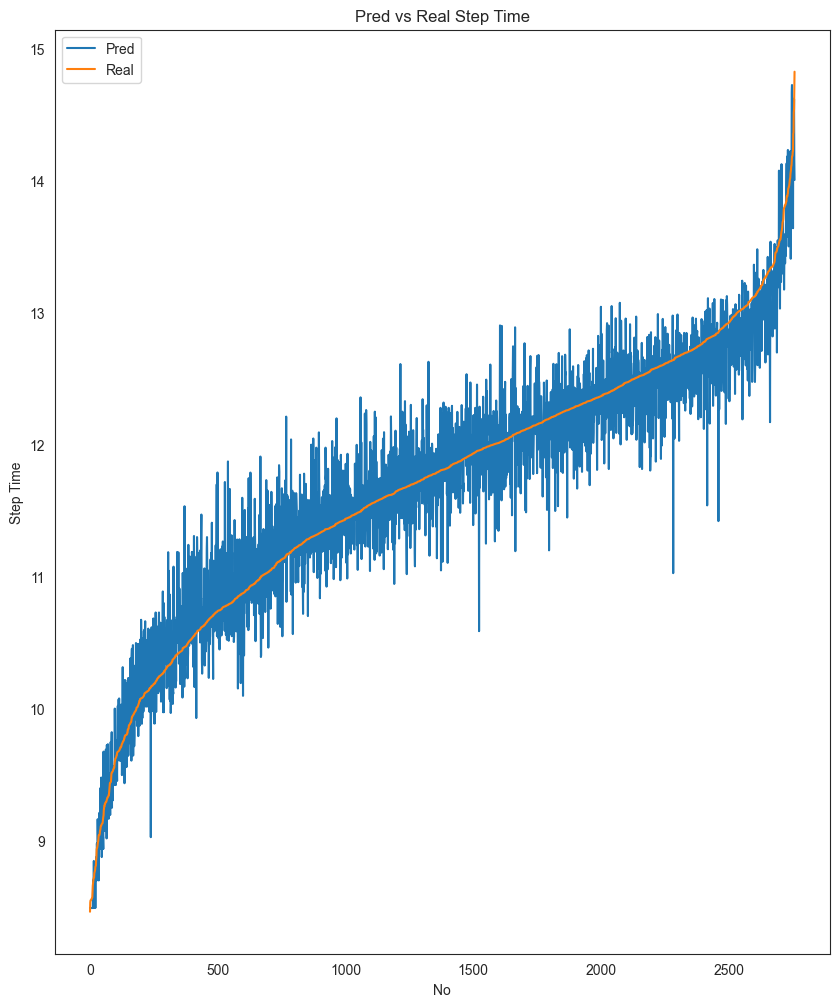

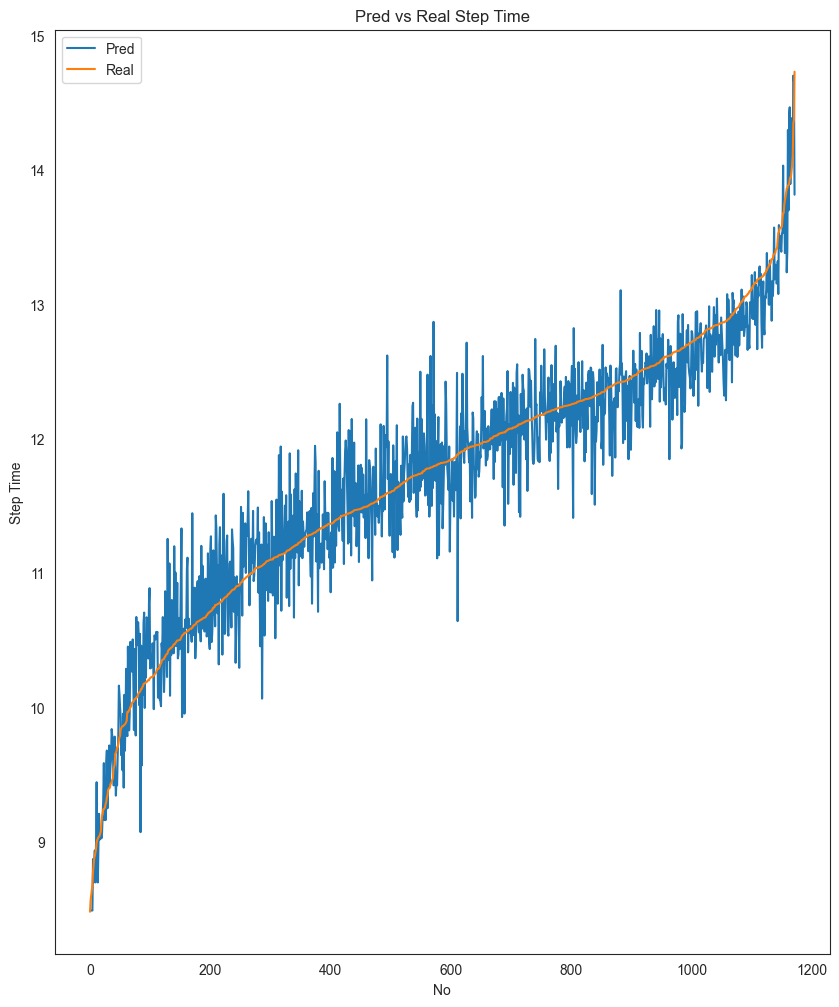

In [21]:
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

In [22]:
lin_regressor = LinearRegression()
lin_regressor.fit(x_train, y_train)

y_data_pred = lin_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

ALL RMSE: 0.2908940054665059


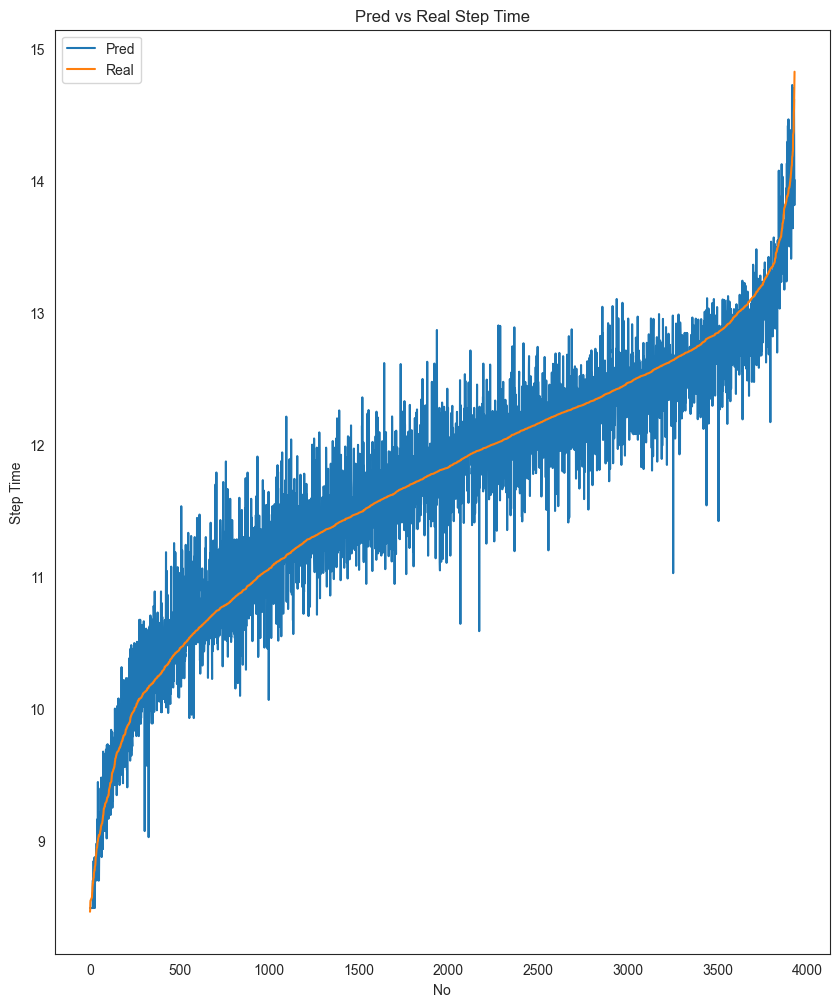

In [23]:
draw_pred_lines(list(y_data_pred[:, -1]), y_data["steps_time"].to_list())

# 2. Decision Tree Regression

In [24]:
dt_regressor = DecisionTreeRegressor()
dt_regressor.fit(x_train, y_train)

y_train_pred = dt_regressor.predict(x_train)
y_test_pred = dt_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)

TRAIN Root Mean Squared Error(RMSE): 0.04797809113132659
TEST Root Mean Squared Error(RMSE): 0.3705611877263879


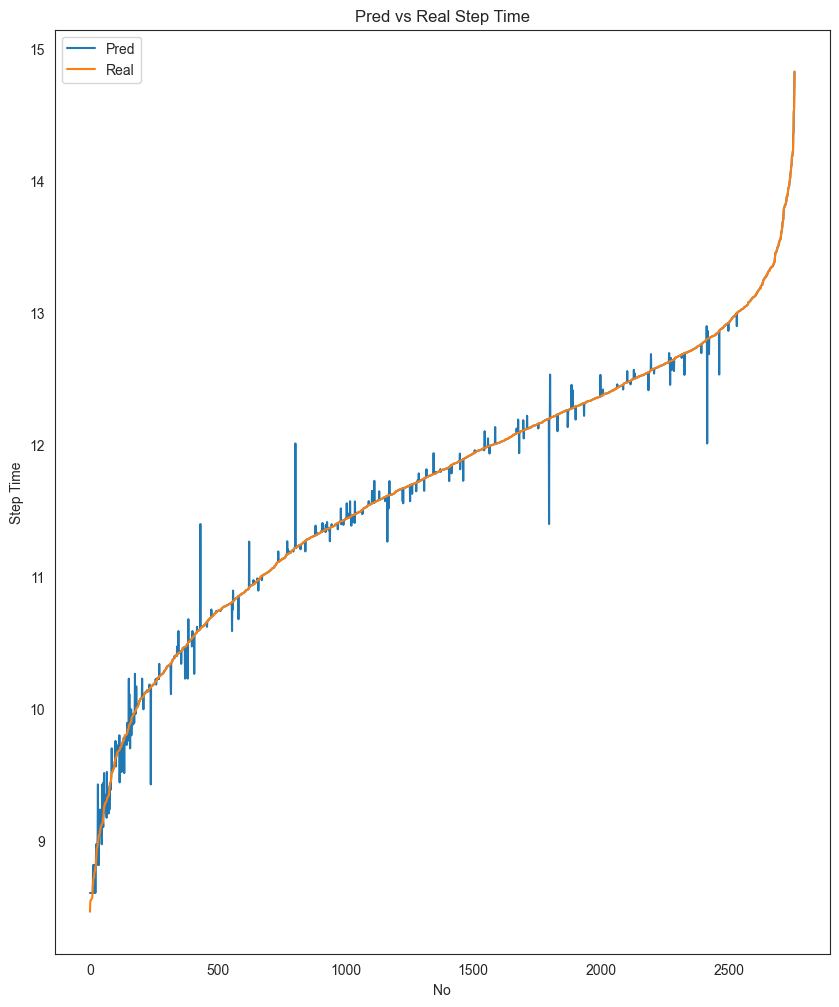

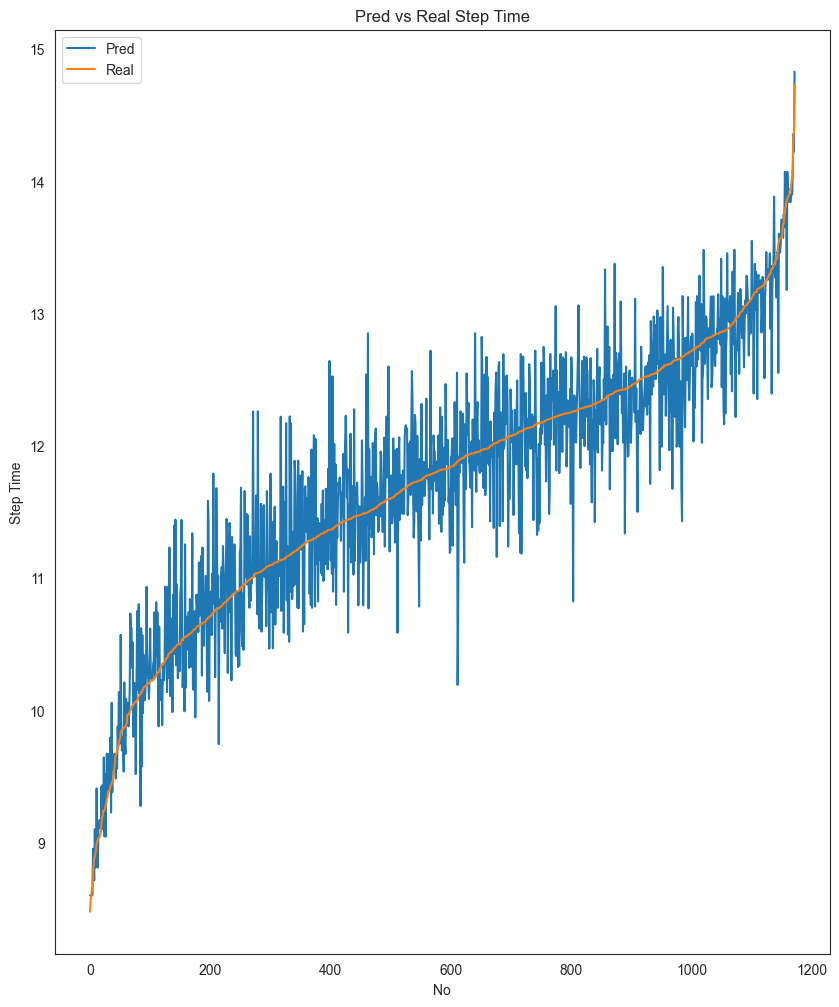

In [25]:
draw_pred_lines(list(y_train_pred), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

In [26]:
dt_regressor = DecisionTreeRegressor()
dt_regressor.fit(x_train, y_train)

y_data_pred = dt_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

ALL RMSE: 0.20609073004140183


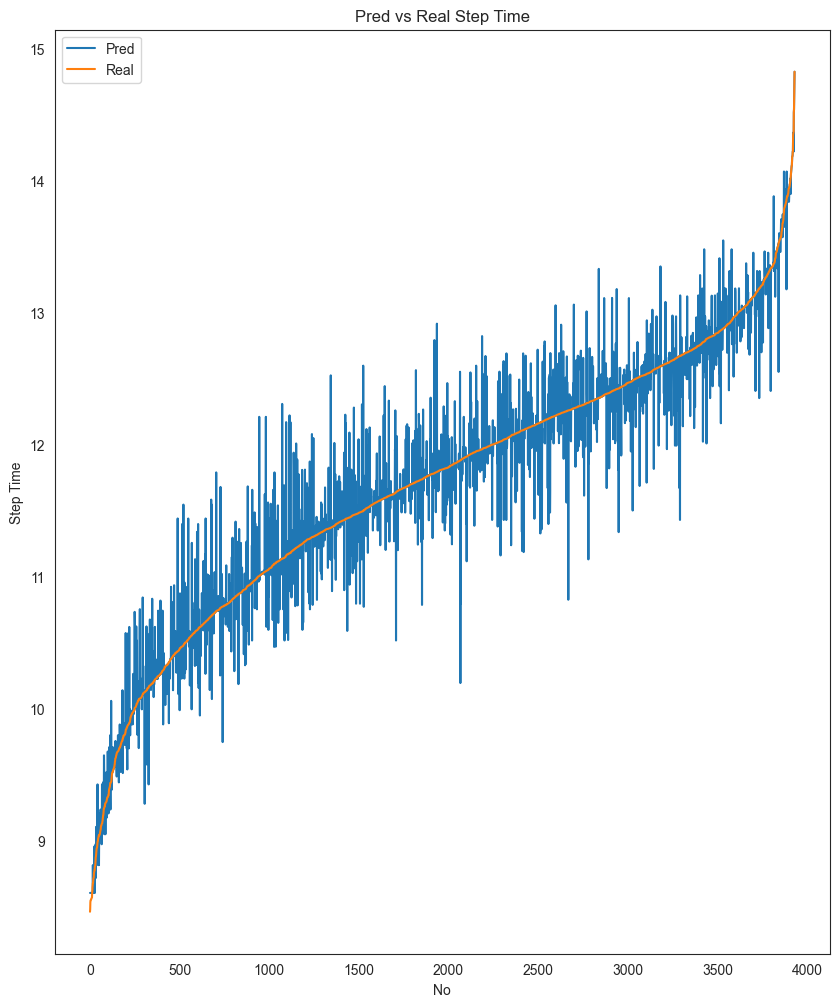

In [27]:
draw_pred_lines(list(y_data_pred), y_data["steps_time"].to_list())

# 3. Random Forest

In [28]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(x_train, y_train)

y_train_pred = rf_regressor.predict(x_train)
y_test_pred = rf_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


TRAIN Root Mean Squared Error(RMSE): 0.11372062608708765
TEST Root Mean Squared Error(RMSE): 0.28456631600091514


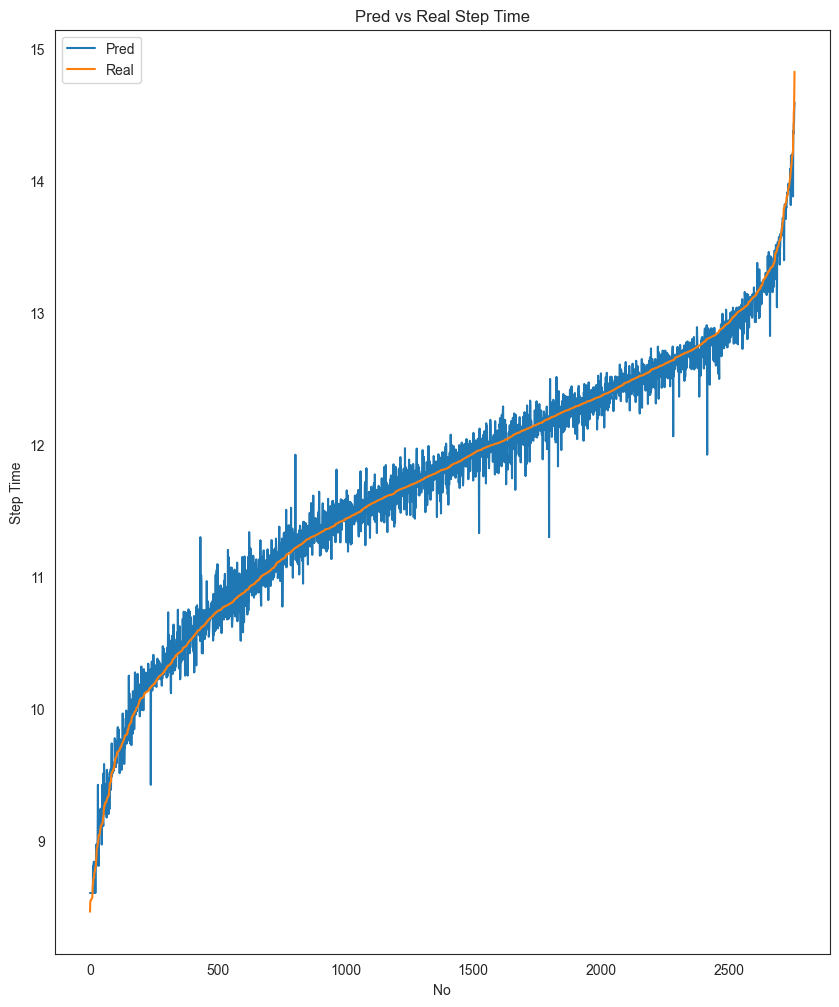

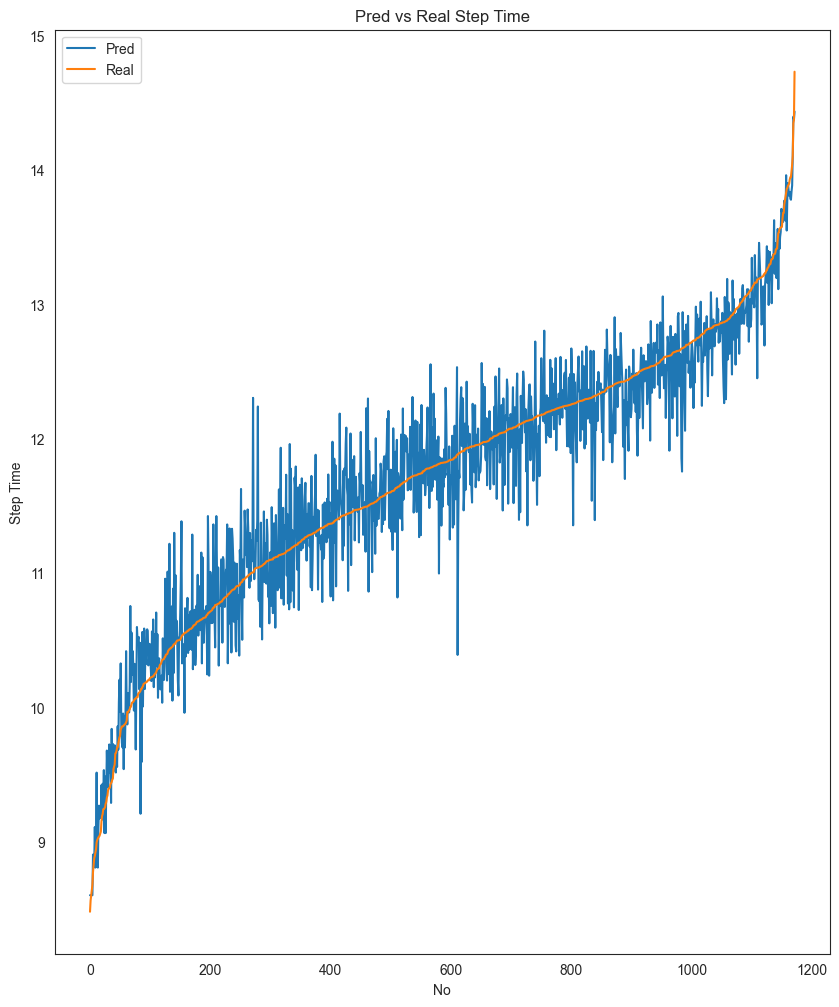

In [29]:
draw_pred_lines(list(y_train_pred), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

In [30]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(x_data, y_data)

y_data_pred = rf_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


ALL RMSE: 0.11348174577853905


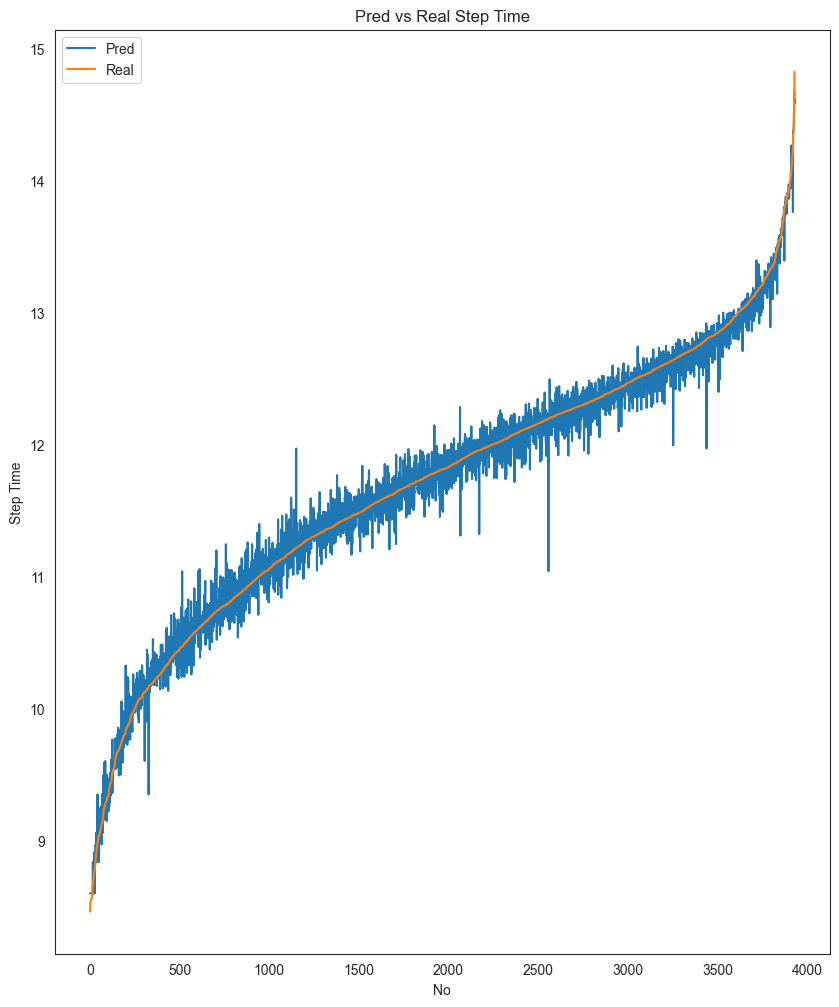

In [31]:
draw_pred_lines(list(y_data_pred), y_data["steps_time"].to_list())

# 4. Support Vector Regression
### kernel='rbf'

In [32]:
svr_regressor = SVR(kernel="rbf")
svr_regressor.fit(x_train, y_train)

y_train_pred = svr_regressor.predict(x_train)
y_test_pred = svr_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN Root Mean Squared Error(RMSE): 0.2927524539766902
TEST Root Mean Squared Error(RMSE): 0.2927763289076395


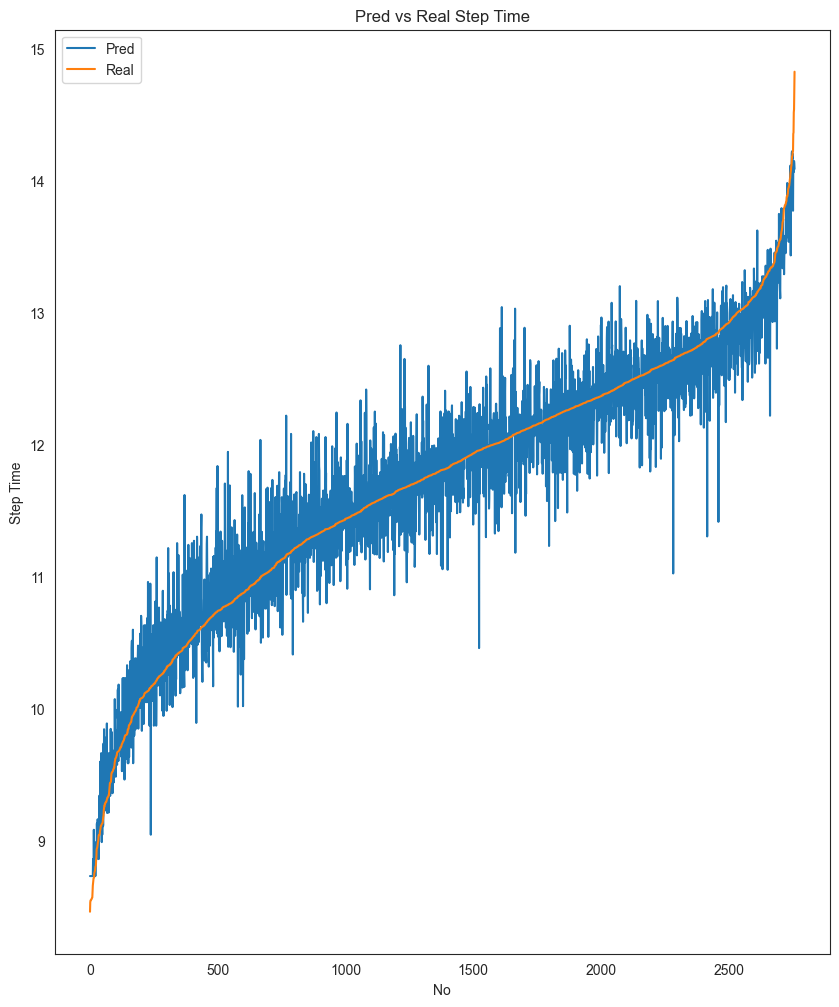

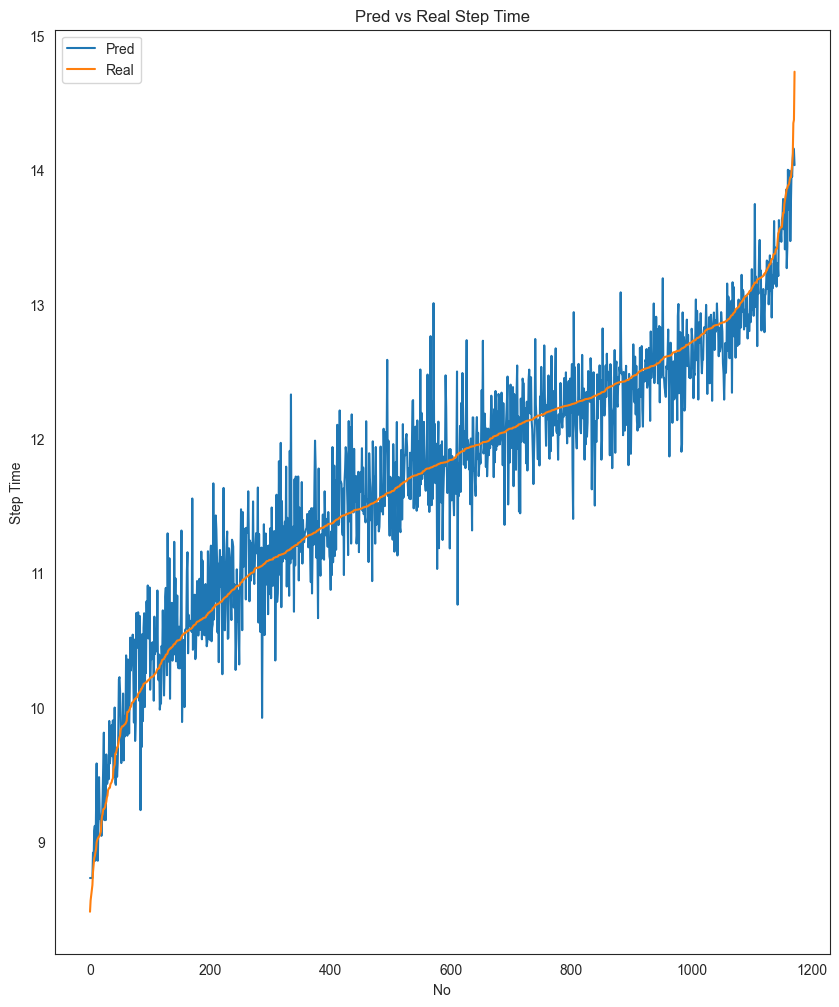

In [33]:
draw_pred_lines(list(y_train_pred), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

In [34]:
svr_regressor = SVR(kernel="rbf")
svr_regressor.fit(x_data, y_data)

y_data_pred = svr_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ALL RMSE: 0.2899364785830641


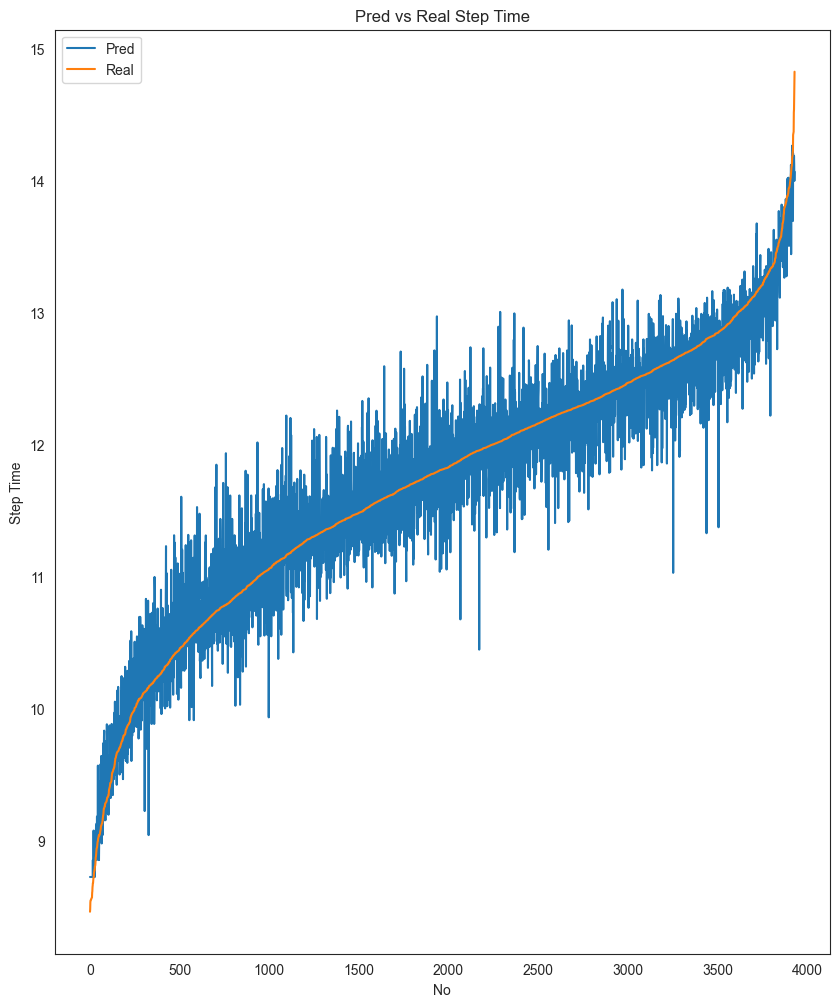

In [35]:
draw_pred_lines(list(y_data_pred), y_data["steps_time"].to_list())

### kernel='linear'

In [36]:
svr_regressor = SVR(kernel="linear")
svr_regressor.fit(x_train, y_train)

y_train_pred = svr_regressor.predict(x_train)
y_test_pred = svr_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)


svr_regressor = SVR(kernel="linear")
svr_regressor.fit(x_data, y_data)

y_data_pred = svr_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN Root Mean Squared Error(RMSE): 0.2920796467798744
TEST Root Mean Squared Error(RMSE): 0.2898971489521111


D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ALL RMSE: 0.291175596333711


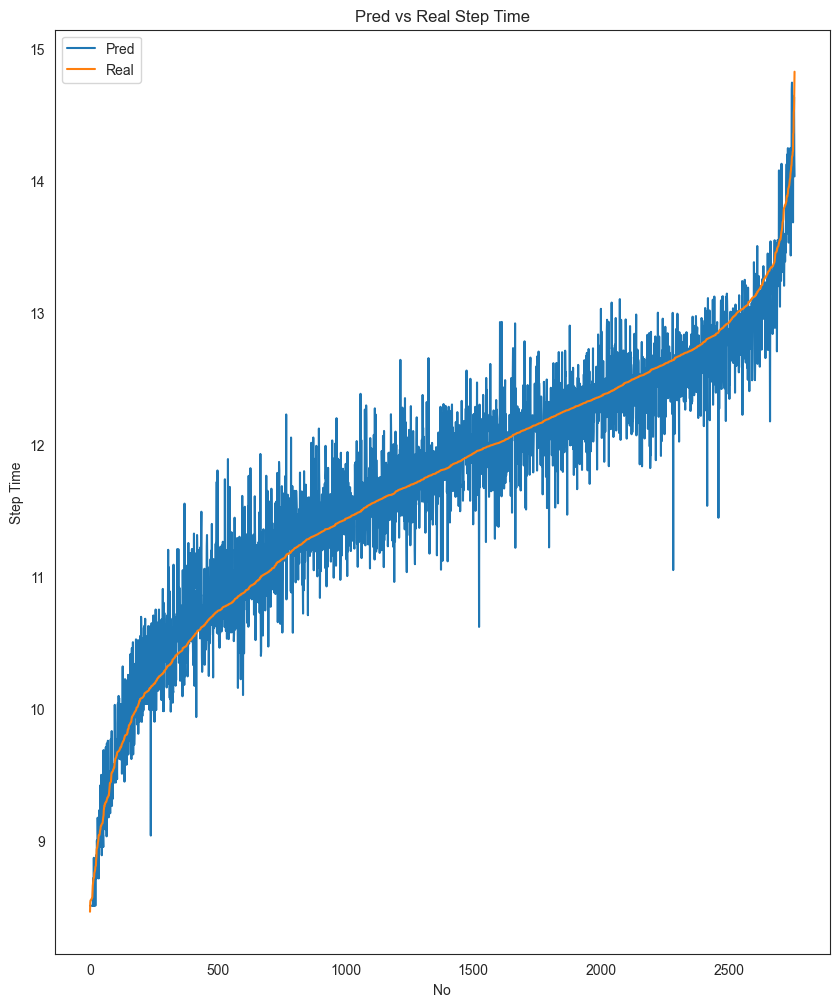

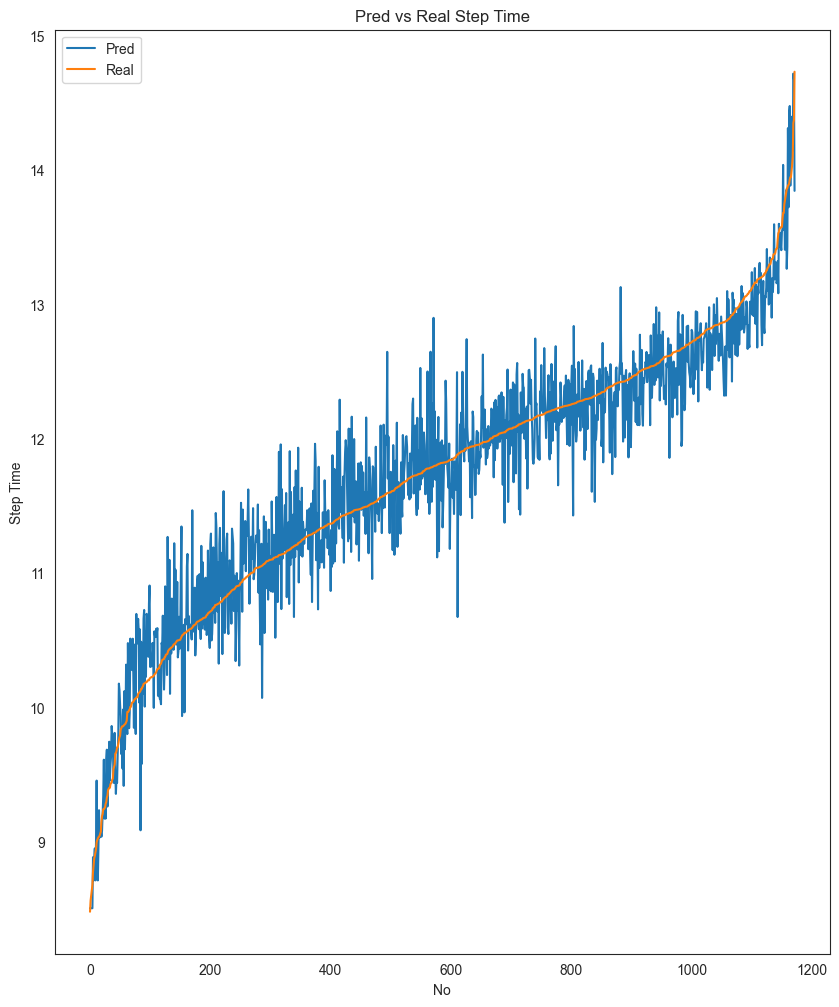

In [37]:
draw_pred_lines(list(y_train_pred), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

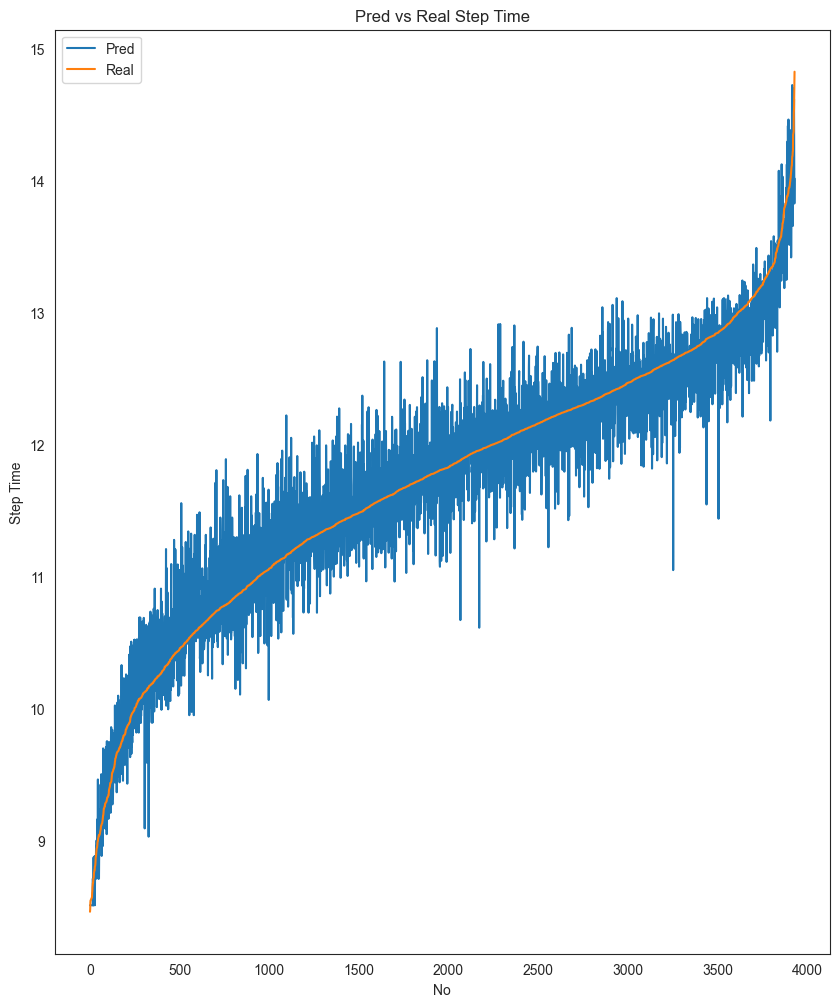

In [38]:
draw_pred_lines(list(y_data_pred), y_data["steps_time"].to_list())

### kernel='poly'

In [39]:
svr_regressor = SVR(kernel="poly")
svr_regressor.fit(x_train, y_train)

y_train_pred = svr_regressor.predict(x_train)
y_test_pred = svr_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)


svr_regressor = SVR(kernel="poly")
svr_regressor.fit(x_data, y_data)

y_data_pred = svr_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN Root Mean Squared Error(RMSE): 0.3892188705917063
TEST Root Mean Squared Error(RMSE): 0.3863626482640943


D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ALL RMSE: 0.38108656768153626


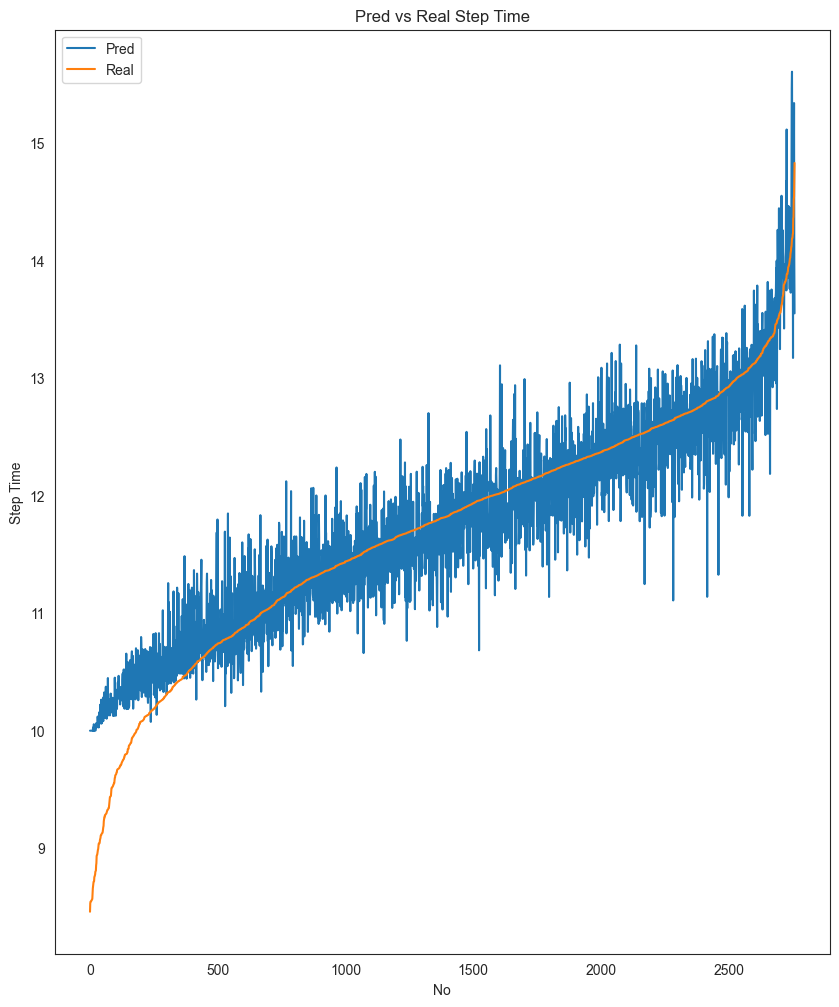

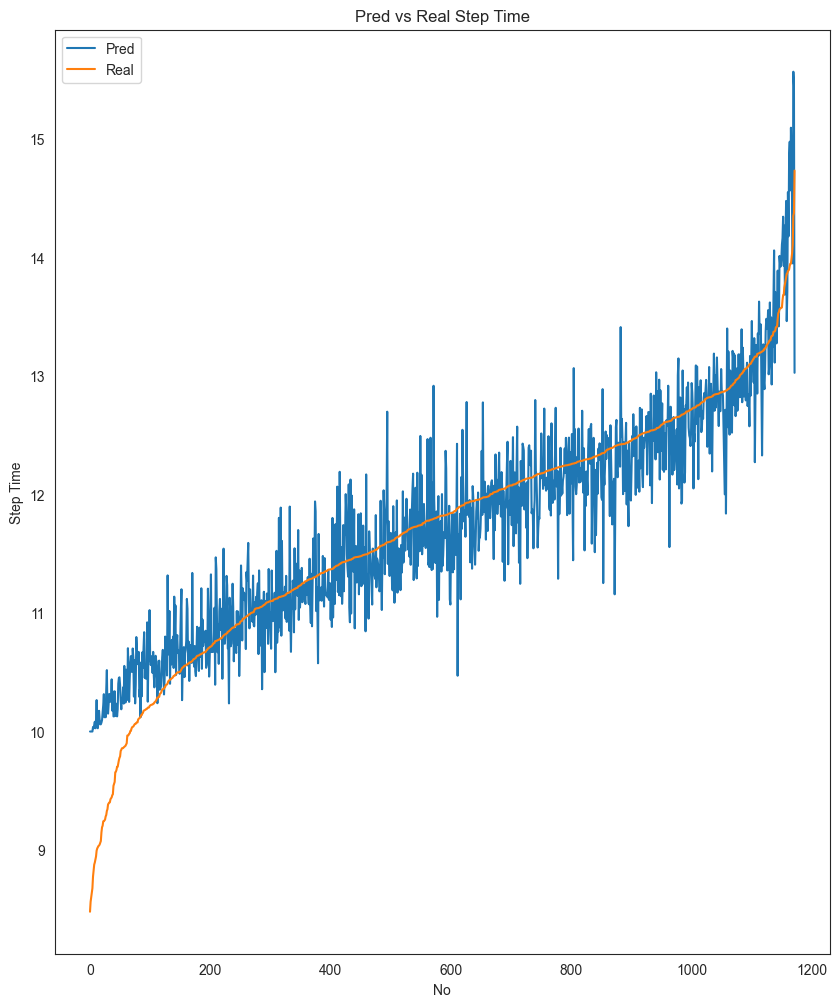

In [40]:
draw_pred_lines(list(y_train_pred), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

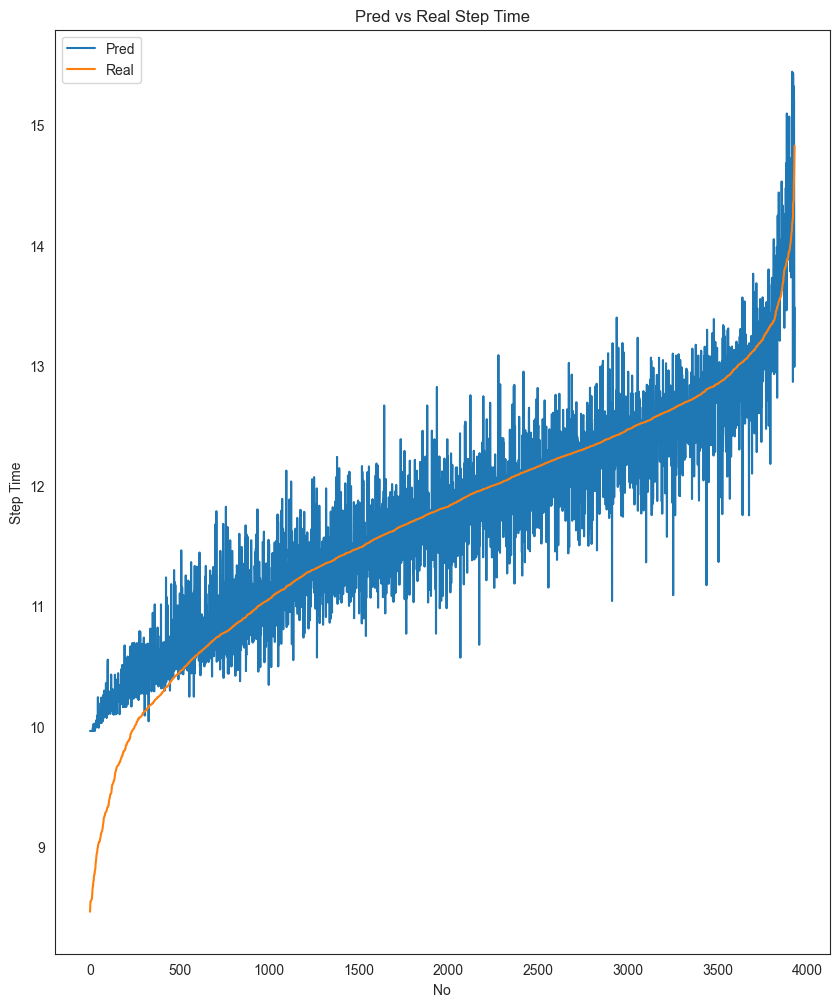

In [41]:
draw_pred_lines(list(y_data_pred), y_data["steps_time"].to_list())

# kernel='sigmoid'

In [42]:
svr_regressor = SVR(kernel="sigmoid")
svr_regressor.fit(x_train, y_train)

y_train_pred = svr_regressor.predict(x_train)
y_test_pred = svr_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)


svr_regressor = SVR(kernel="sigmoid")
svr_regressor.fit(x_data, y_data)

y_data_pred = svr_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN Root Mean Squared Error(RMSE): 66.2409347315108
TEST Root Mean Squared Error(RMSE): 68.0336992570482


D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ALL RMSE: 95.24439411559179


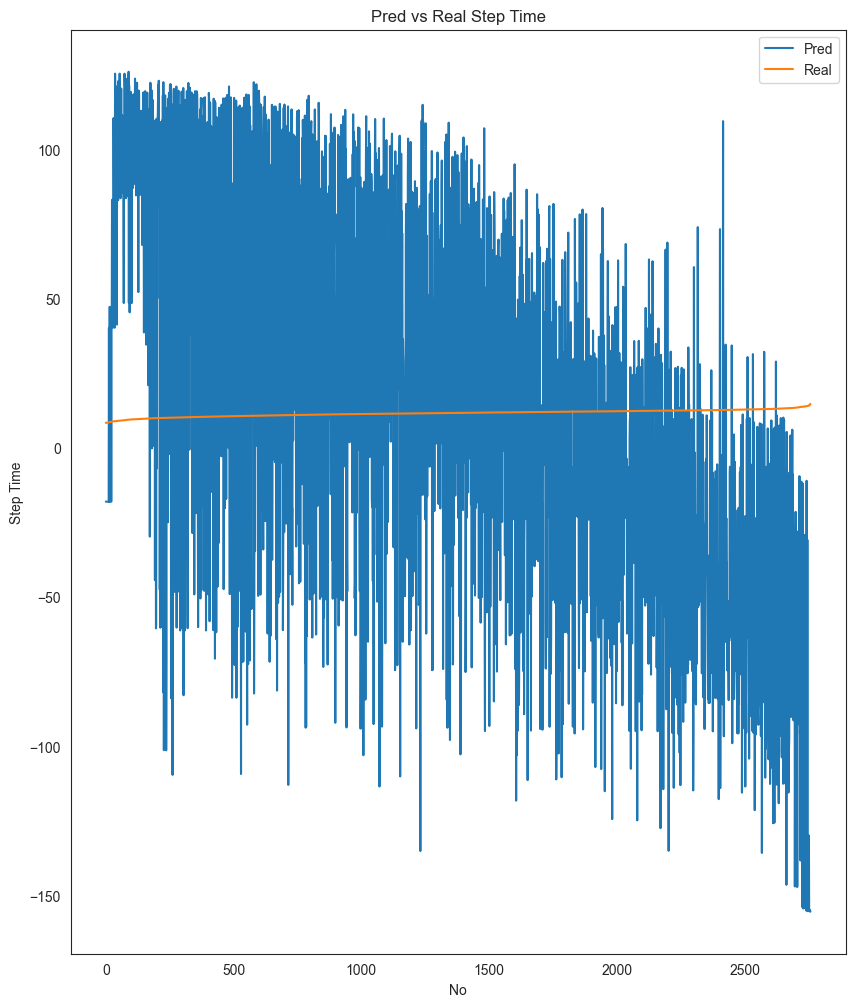

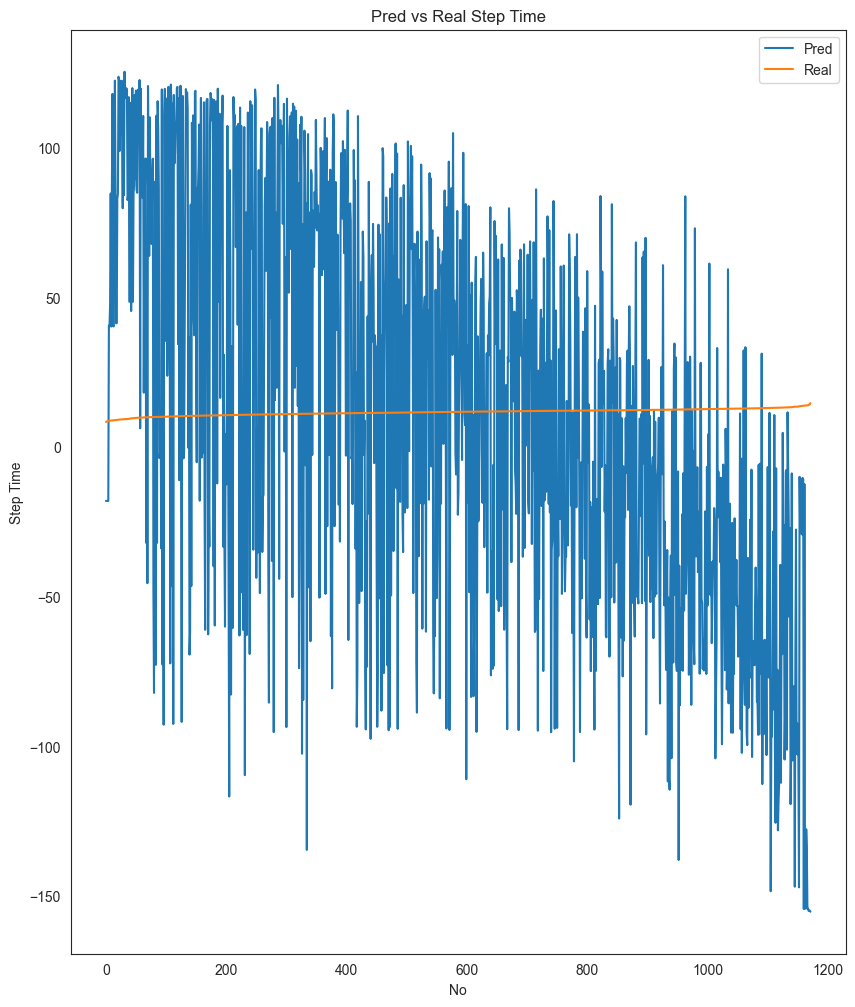

In [43]:
draw_pred_lines(list(y_train_pred), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

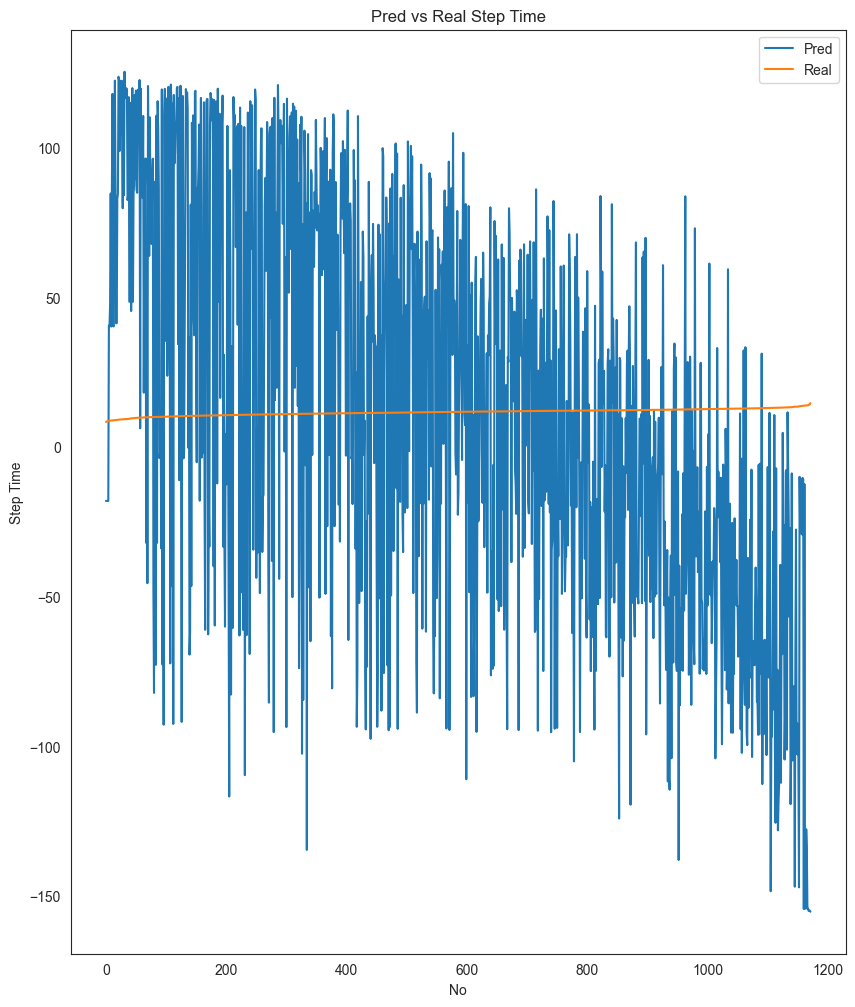

In [44]:
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

# 5. K-Nearest Neighbors Regression

In [45]:
neighbors = 3

knn_regressor = KNeighborsRegressor(n_neighbors=neighbors)
knn_regressor.fit(x_train, y_train)

y_train_pred = knn_regressor.predict(x_train)
y_test_pred = knn_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)


knn_regressor = KNeighborsRegressor(n_neighbors=neighbors)
knn_regressor.fit(x_data, y_data)

y_data_pred = knn_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

TRAIN Root Mean Squared Error(RMSE): 0.2187497114397444
TEST Root Mean Squared Error(RMSE): 0.32431049123972955
ALL RMSE: 0.21459911732459896


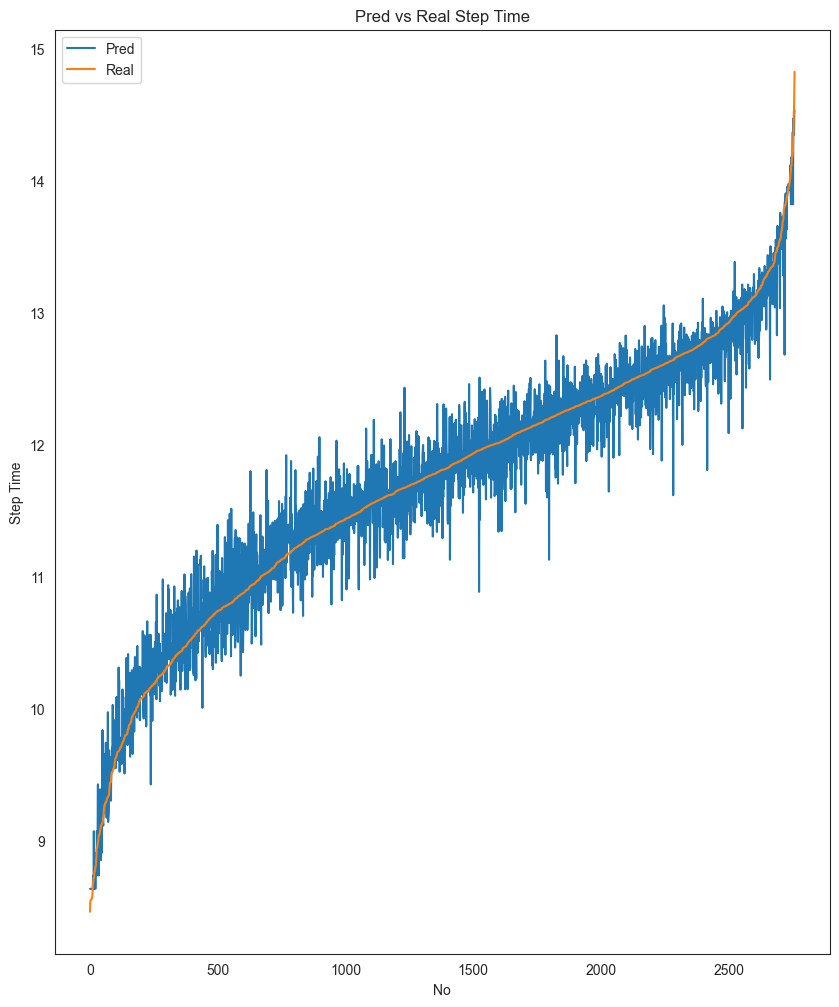

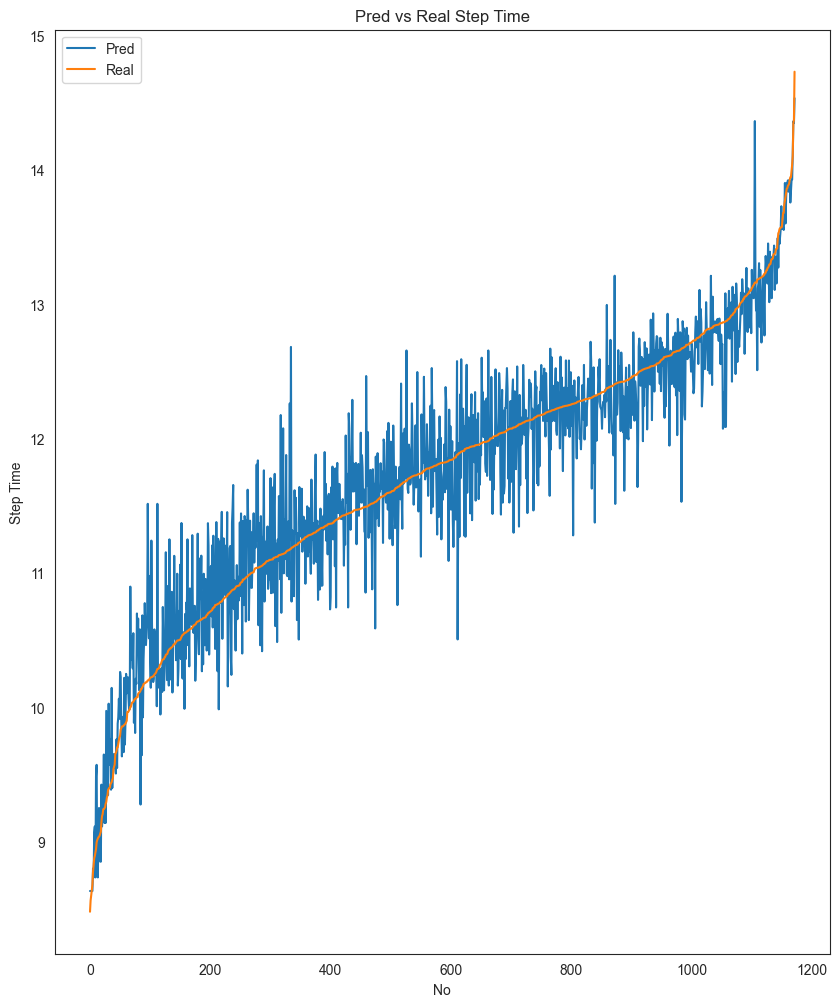

In [46]:
draw_pred_lines(list(y_train_pred), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

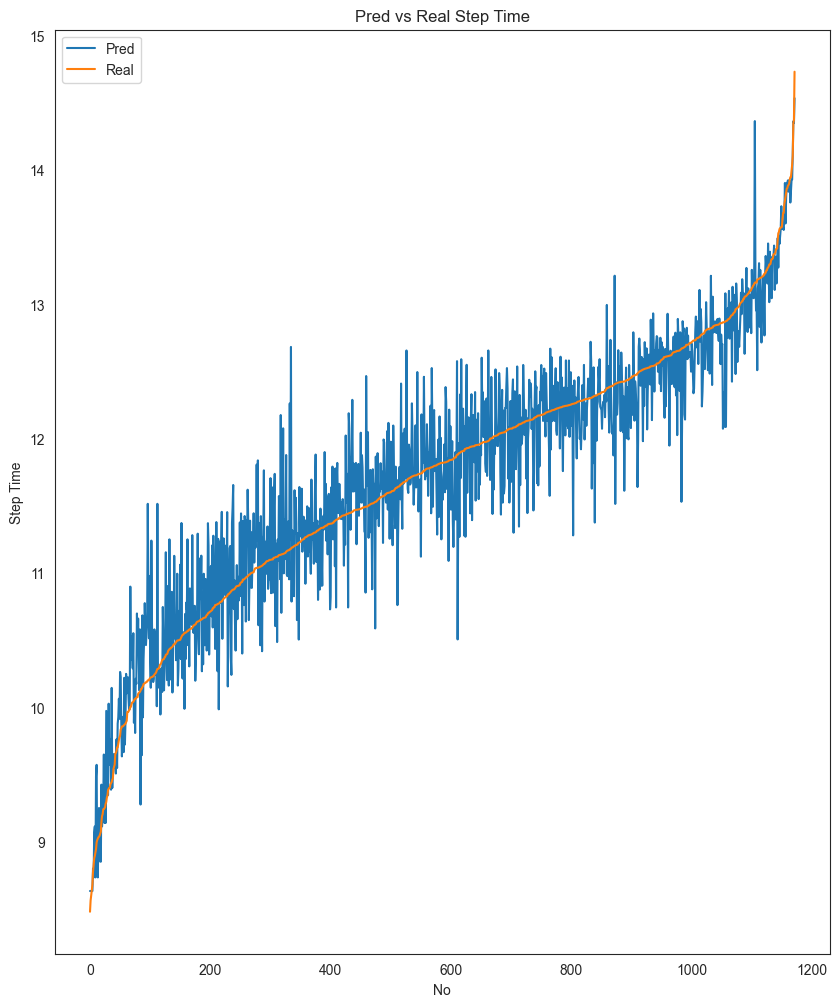

In [47]:
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

In [48]:
neighbors = 6

knn_regressor = KNeighborsRegressor(n_neighbors=neighbors)
knn_regressor.fit(x_train, y_train)

y_train_pred = knn_regressor.predict(x_train)
y_test_pred = knn_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)


knn_regressor = KNeighborsRegressor(n_neighbors=neighbors)
knn_regressor.fit(x_data, y_data)

y_data_pred = knn_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

TRAIN Root Mean Squared Error(RMSE): 0.2638625788851095
TEST Root Mean Squared Error(RMSE): 0.3149742884466841
ALL RMSE: 0.2532857538174605


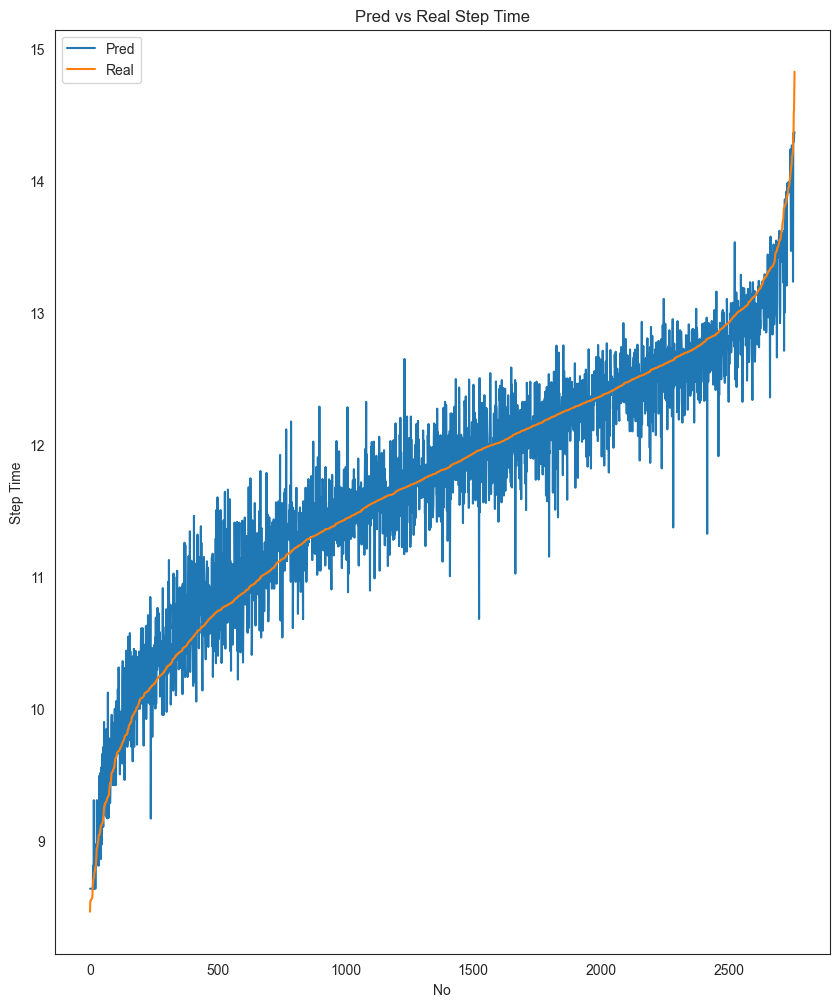

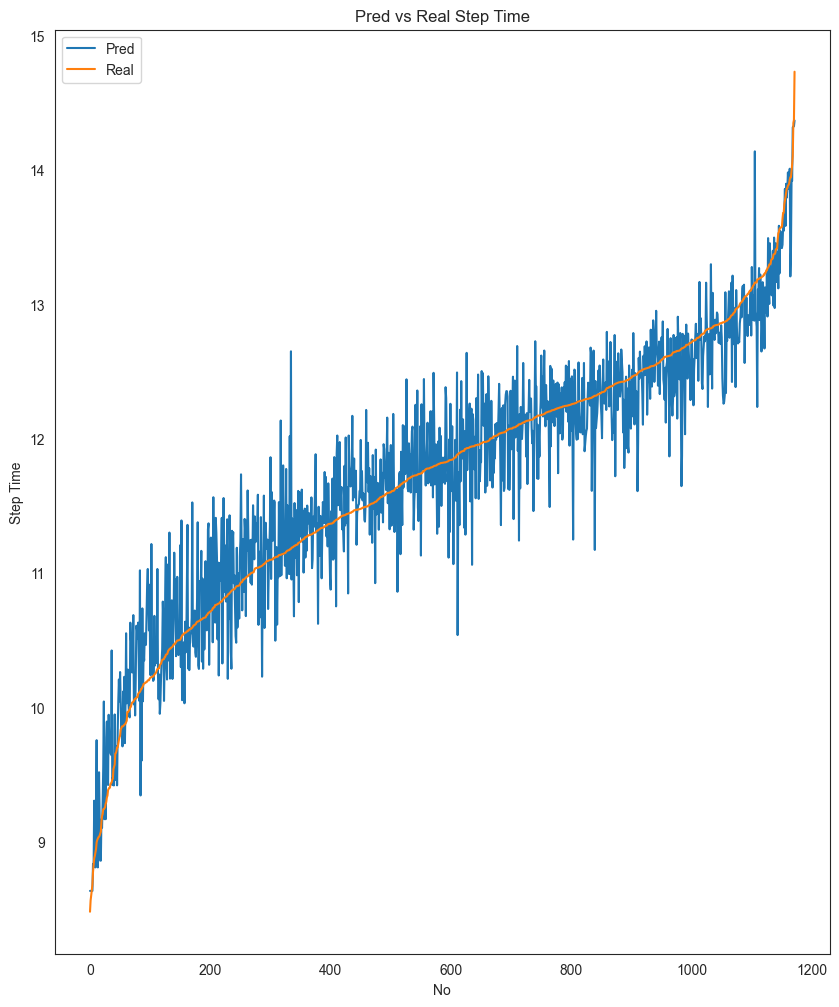

In [49]:
draw_pred_lines(list(y_train_pred), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

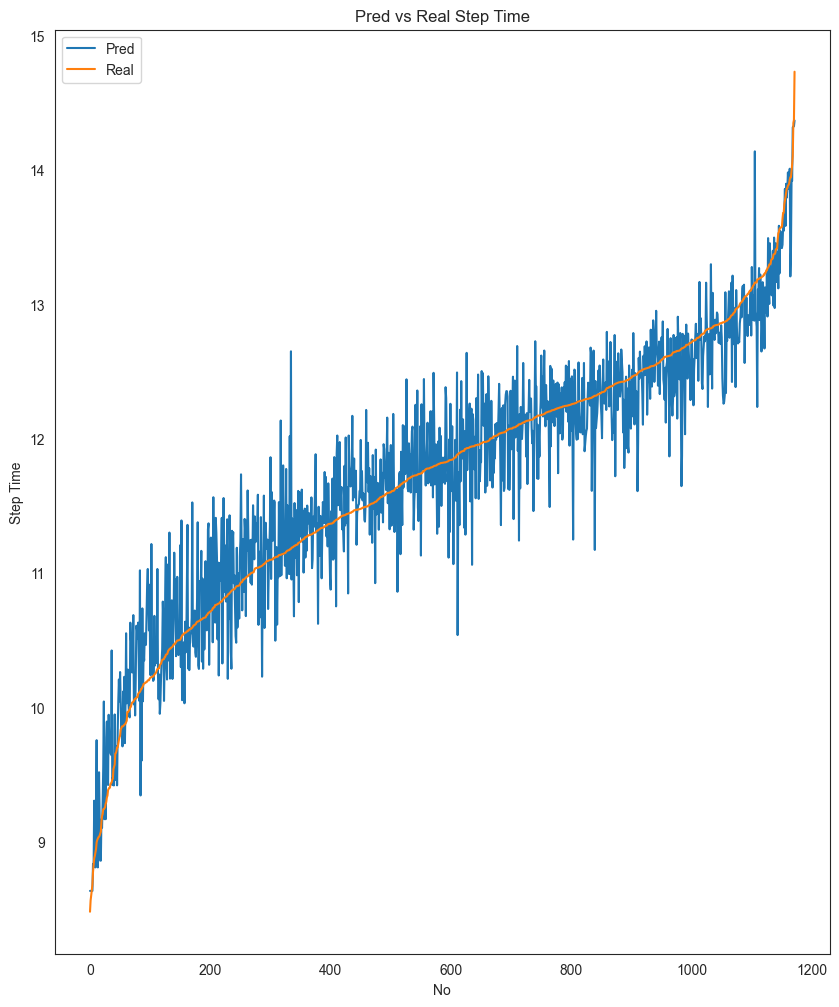

In [50]:
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

In [51]:
neighbors = 10

knn_regressor = KNeighborsRegressor(n_neighbors=neighbors)
knn_regressor.fit(x_train, y_train)

y_train_pred = knn_regressor.predict(x_train)
y_test_pred = knn_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)


knn_regressor = KNeighborsRegressor(n_neighbors=neighbors)
knn_regressor.fit(x_data, y_data)

y_data_pred = knn_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

TRAIN Root Mean Squared Error(RMSE): 0.2890870644764379
TEST Root Mean Squared Error(RMSE): 0.3187252801598035
ALL RMSE: 0.27932231588299444


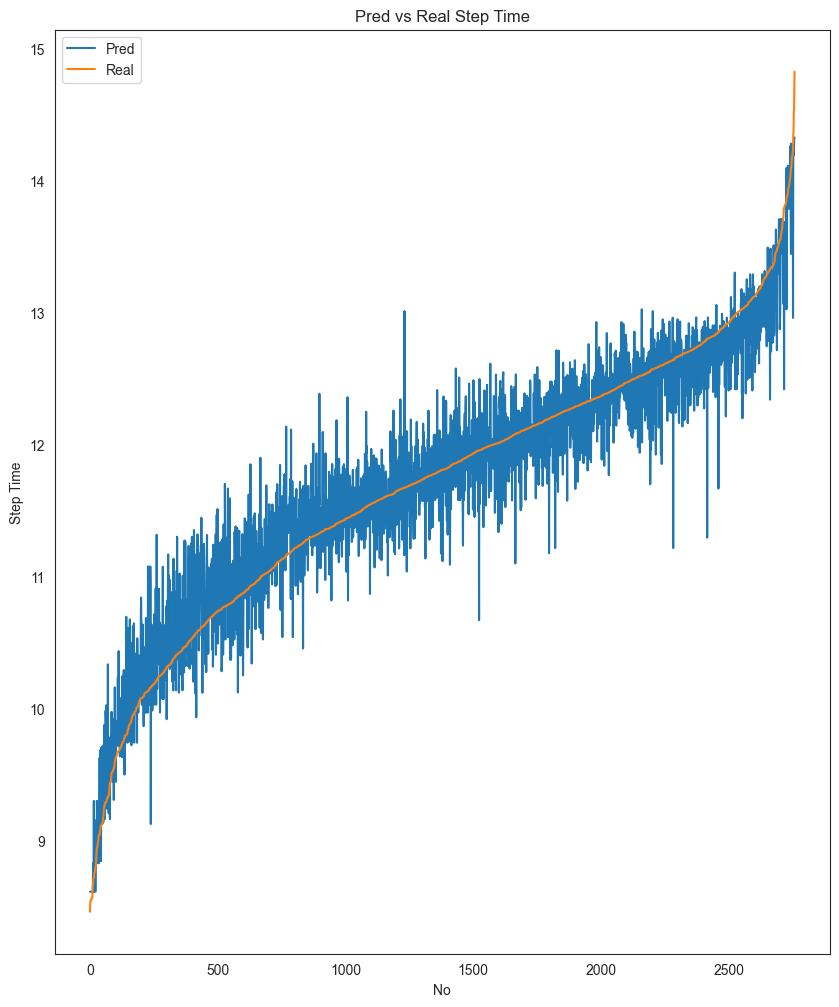

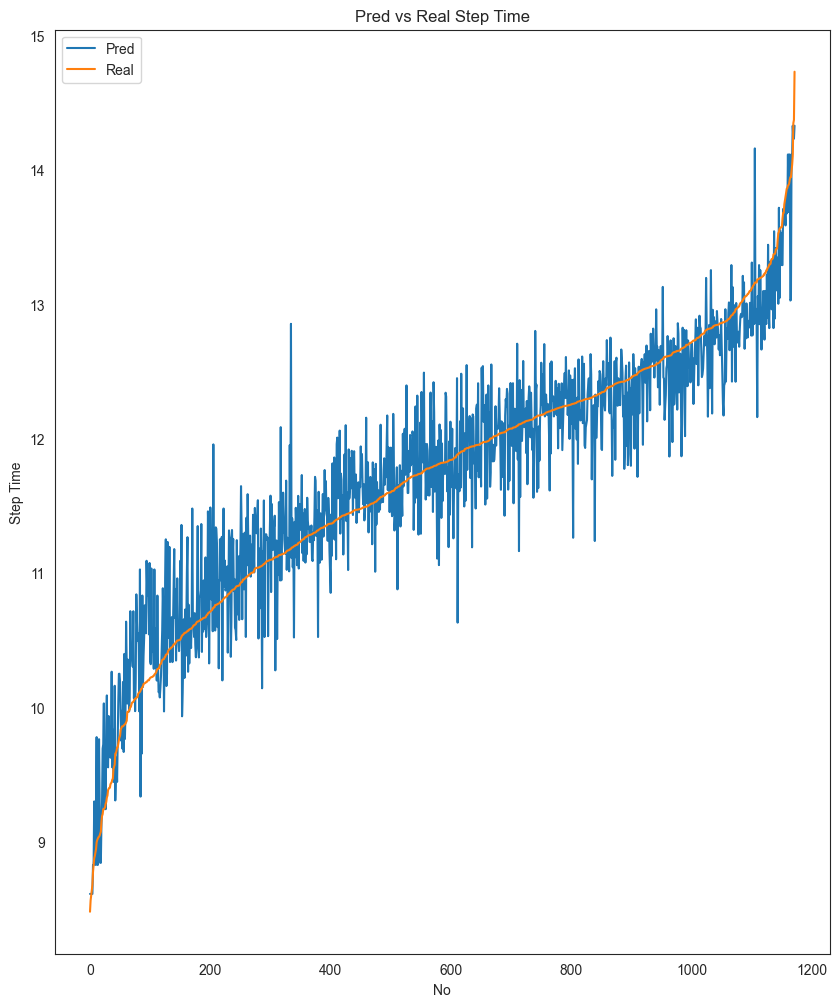

In [52]:
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

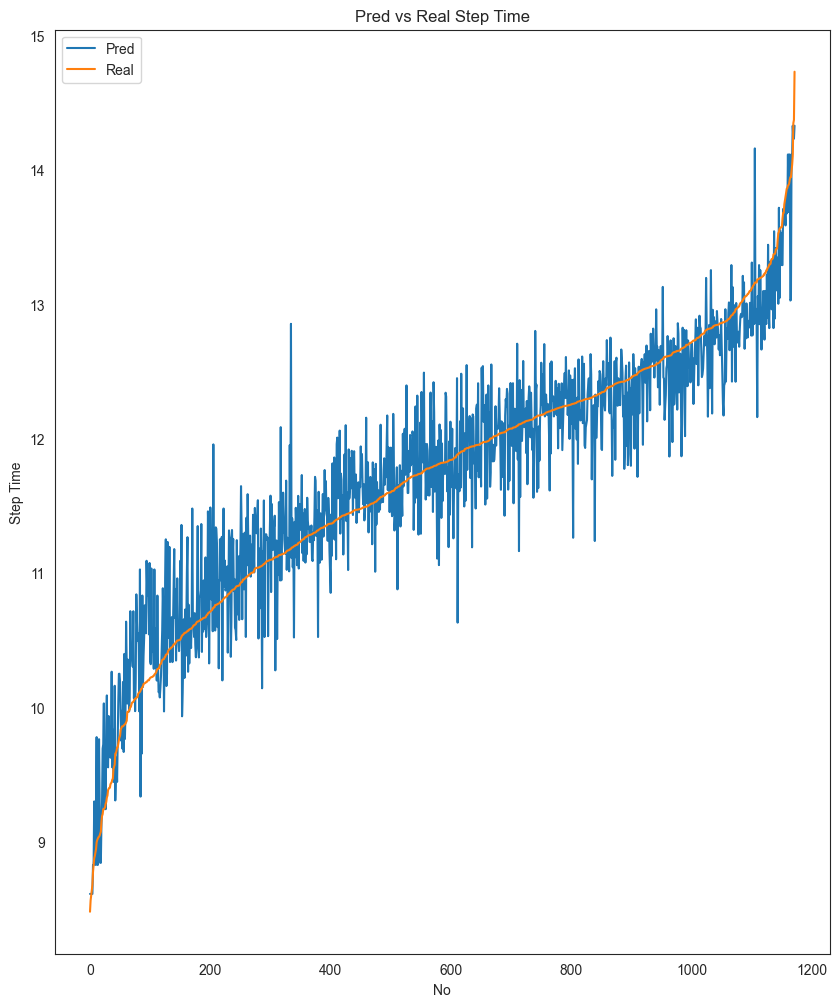

In [53]:
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

In [54]:
neighbors = 20

knn_regressor = KNeighborsRegressor(n_neighbors=neighbors)
knn_regressor.fit(x_train, y_train)

y_train_pred = knn_regressor.predict(x_train)
y_test_pred = knn_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)


knn_regressor = KNeighborsRegressor(n_neighbors=neighbors)
knn_regressor.fit(x_data, y_data)

y_data_pred = knn_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

TRAIN Root Mean Squared Error(RMSE): 0.3205583425817943
TEST Root Mean Squared Error(RMSE): 0.3348344240276373
ALL RMSE: 0.30671423967550066


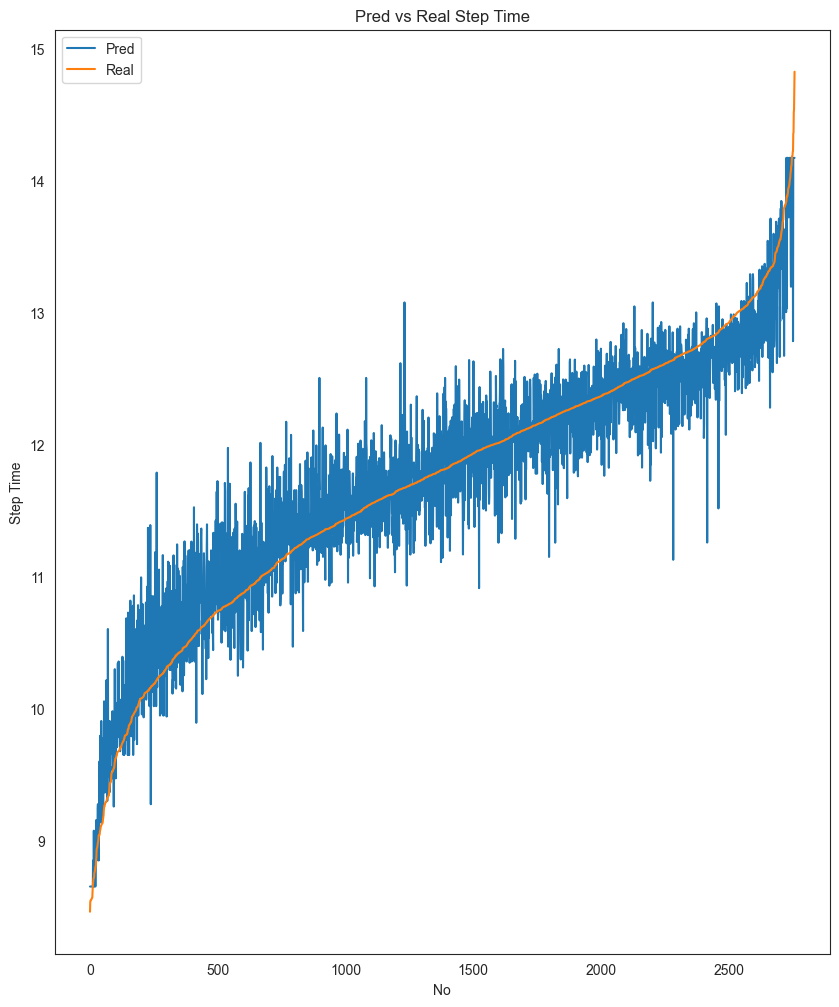

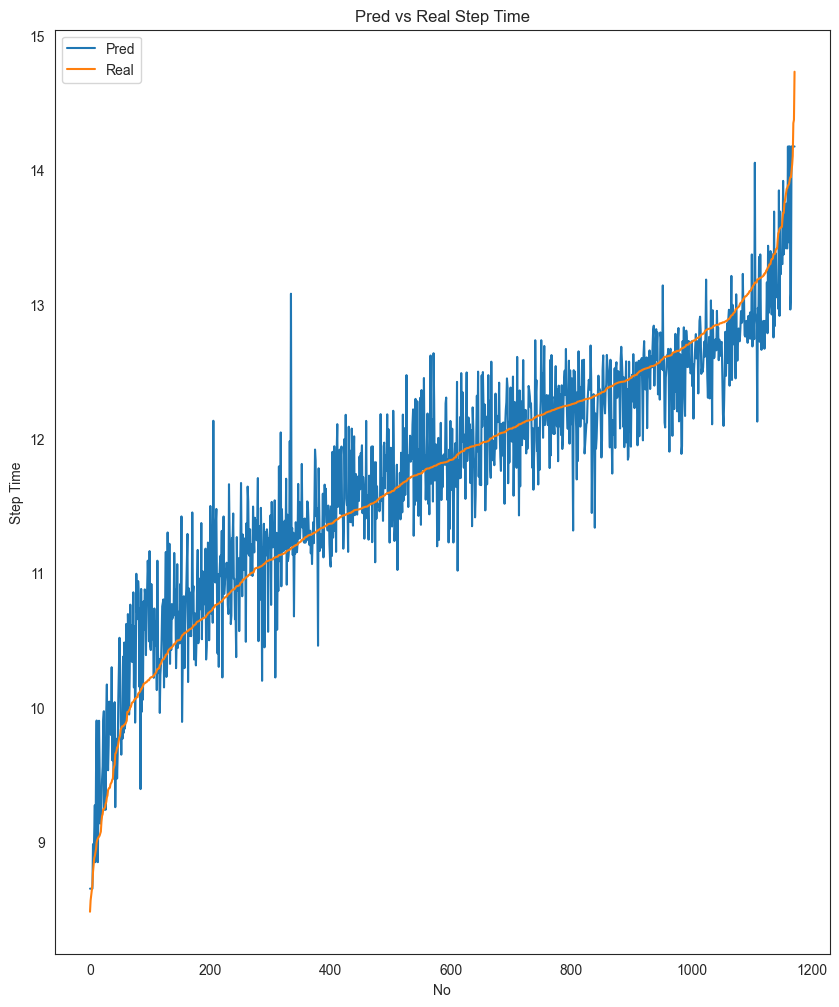

In [55]:
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

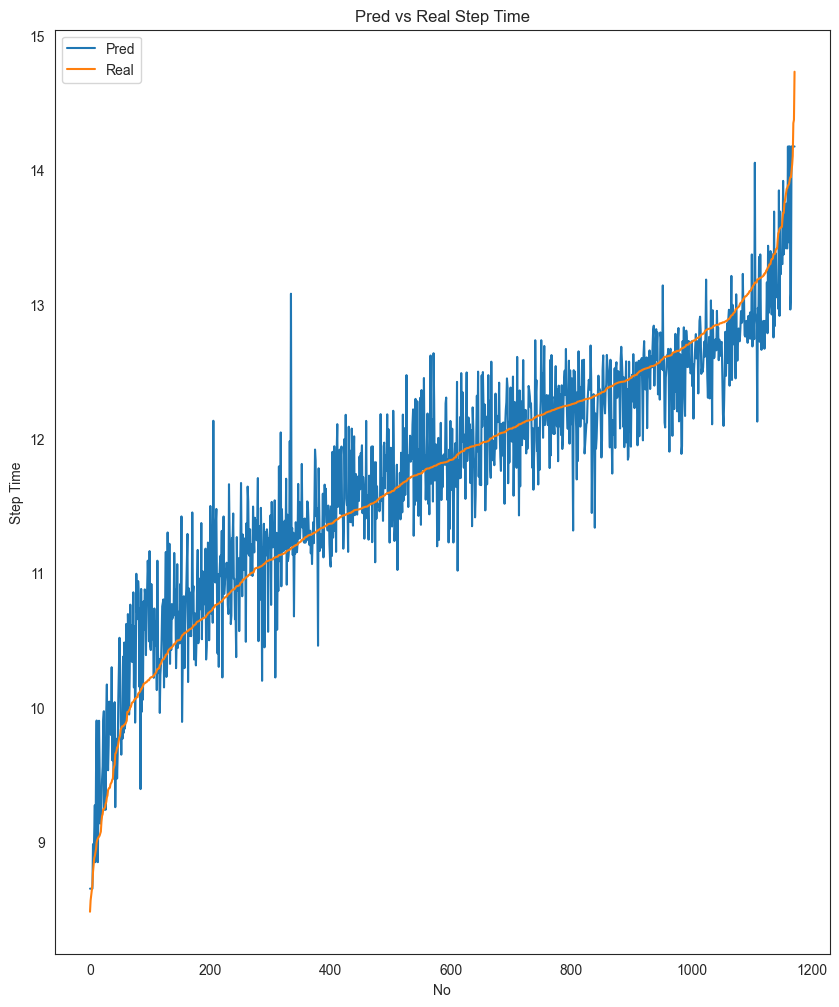

In [56]:
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

# 6. ANN Regression

In [58]:
rcParams["figure.figsize"] = 7, 5

In [59]:
model = Sequential()
model.add(Dense(units=10, activation='relu', input_dim=5))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=300)

Epoch 1/100
10/10 [==============================] - 1s 16ms/step - loss: 92.9862 - val_loss: 89.1569
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 88.0007 - val_loss: 85.3486
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 84.4412 - val_loss: 81.9979
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 81.1811 - val_loss: 78.8315
Epoch 5/100
10/10 [==============================] - 0s 7ms/step - loss: 78.0544 - val_loss: 75.7243
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 74.9797 - val_loss: 72.6515
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 71.9258 - val_loss: 69.6056
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 68.8930 - val_loss: 66.5677
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 65.8621 - val_loss: 63.5239
Epoch 10/100
10/10 [==============================] - 0s 4ms/step - loss: 62.8363 - val_lo

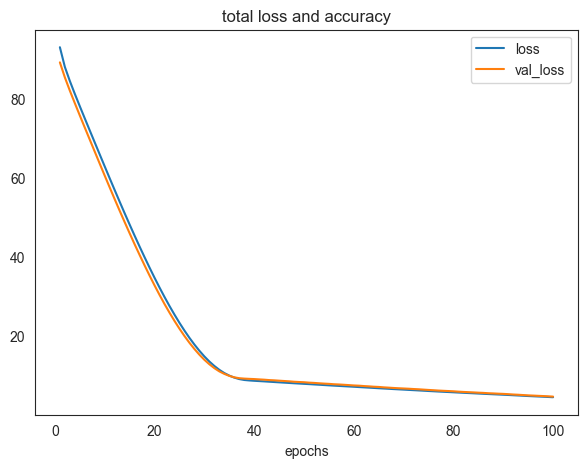

In [60]:
epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
val_loss_array = history.history['val_loss']

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, val_loss_array, label="val_loss")
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

In [61]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
print("ALL RMSE:", rmse_all)

123/123 [==============================] - 0s 760us/step
TRAIN Root Mean Squared Error(RMSE): 2.1023864225808526
TEST Root Mean Squared Error(RMSE): 2.147637062328302
ALL RMSE: 2.115978828269373


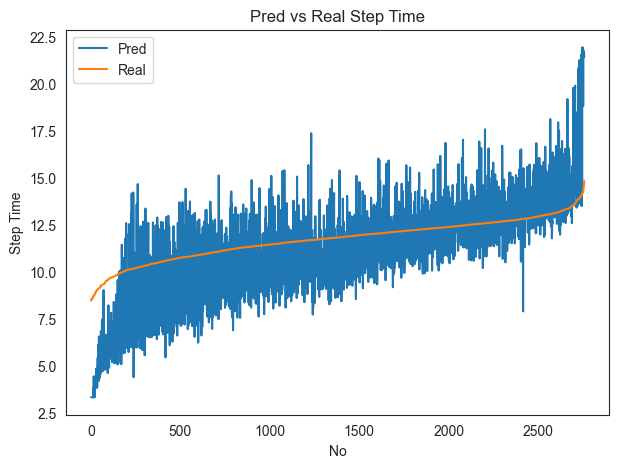

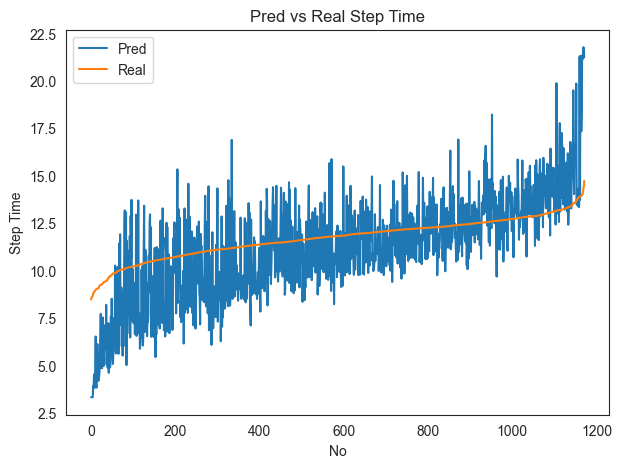

In [62]:
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

In [63]:
model = Sequential()
model.add(Dense(units=10, activation='relu', input_dim=5))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=1)

Epoch 1/100
2759/2759 [==============================] - 4s 1ms/step - loss: 5.1694 - val_loss: 1.3092
Epoch 2/100
2759/2759 [==============================] - 3s 1ms/step - loss: 0.6396 - val_loss: 0.2662
Epoch 3/100
2759/2759 [==============================] - 4s 1ms/step - loss: 0.1996 - val_loss: 0.1902
Epoch 4/100
2759/2759 [==============================] - 3s 1ms/step - loss: 0.1253 - val_loss: 0.1053
Epoch 5/100
2759/2759 [==============================] - 3s 1ms/step - loss: 0.1180 - val_loss: 0.1015
Epoch 6/100
2759/2759 [==============================] - 4s 1ms/step - loss: 0.1158 - val_loss: 0.1420
Epoch 7/100
2759/2759 [==============================] - 4s 1ms/step - loss: 0.1139 - val_loss: 0.0943
Epoch 8/100
2759/2759 [==============================] - 4s 1ms/step - loss: 0.1139 - val_loss: 0.1254
Epoch 9/100
2759/2759 [==============================] - 3s 1ms/step - loss: 0.1141 - val_loss: 0.0922
Epoch 10/100
2759/2759 [==============================] - 3s 1ms/step - l

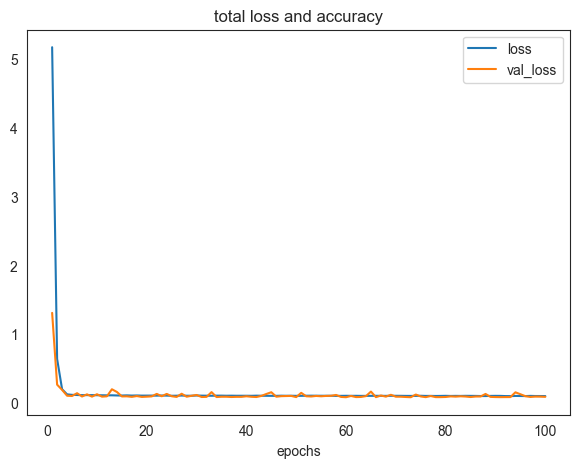

In [64]:
epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
val_loss_array = history.history['val_loss']

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, val_loss_array, label='val_loss')
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

123/123 [==============================] - 0s 783us/step
TRAIN Root Mean Squared Error(RMSE): 0.30017547457024596
TEST Root Mean Squared Error(RMSE): 0.29886798805822884
ALL RMSE: 0.2997862587892359


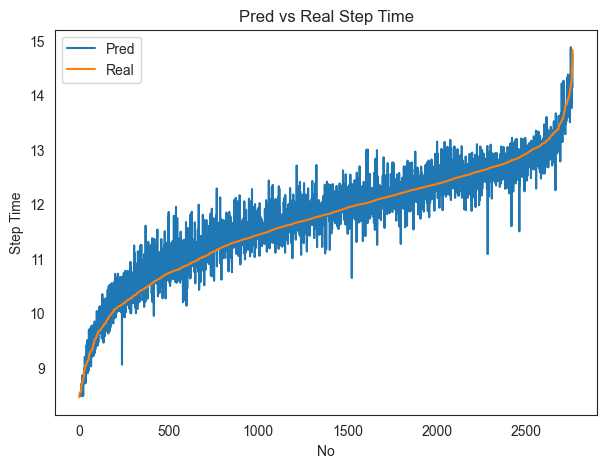

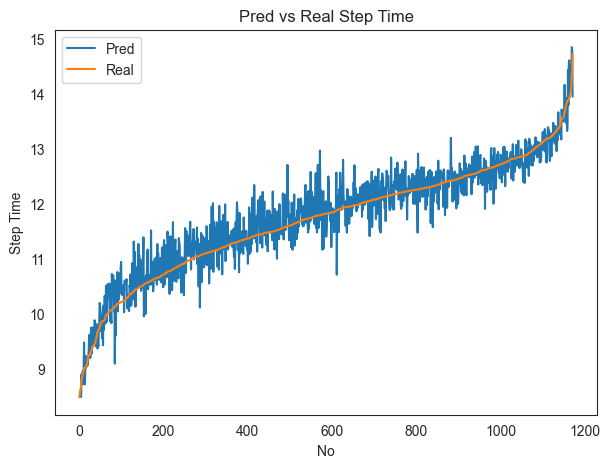

In [65]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
print("ALL RMSE:", rmse_all)
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

In [66]:
model = Sequential()
model.add(Dense(units=20, activation='relu', input_dim=5))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=1)

Epoch 1/100
2759/2759 [==============================] - 3s 1ms/step - loss: 2.2212 - val_loss: 0.4556
Epoch 2/100
2759/2759 [==============================] - 3s 1ms/step - loss: 0.2875 - val_loss: 0.1709
Epoch 3/100
2759/2759 [==============================] - 3s 1ms/step - loss: 0.1452 - val_loss: 0.3634
Epoch 4/100
2759/2759 [==============================] - 3s 1ms/step - loss: 0.1351 - val_loss: 0.1467
Epoch 5/100
2759/2759 [==============================] - 3s 1ms/step - loss: 0.1343 - val_loss: 0.1748
Epoch 6/100
2759/2759 [==============================] - 3s 1ms/step - loss: 0.1314 - val_loss: 0.2707
Epoch 7/100
2759/2759 [==============================] - 3s 1ms/step - loss: 0.1327 - val_loss: 0.1242
Epoch 8/100
2759/2759 [==============================] - 3s 1ms/step - loss: 0.1271 - val_loss: 0.1121
Epoch 9/100
2759/2759 [==============================] - 3s 1ms/step - loss: 0.1295 - val_loss: 0.1030
Epoch 10/100
2759/2759 [==============================] - 3s 1ms/step - l

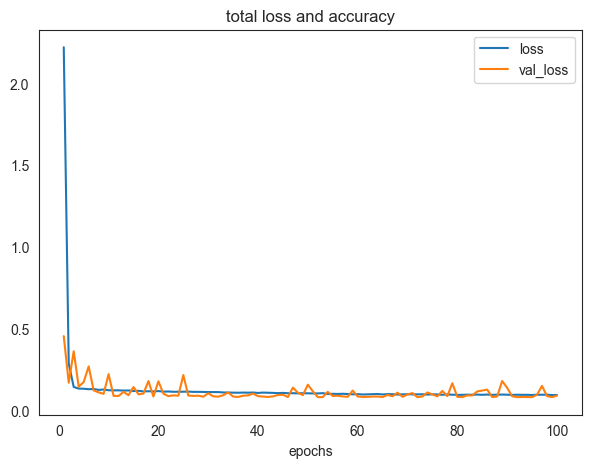

In [67]:
epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
val_loss_array = history.history['val_loss']

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, val_loss_array, label='val_loss')
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

123/123 [==============================] - 0s 759us/step
TRAIN Root Mean Squared Error(RMSE): 0.2983650304269421
TEST Root Mean Squared Error(RMSE): 0.30380017042728186
ALL RMSE: 0.2999957864432219


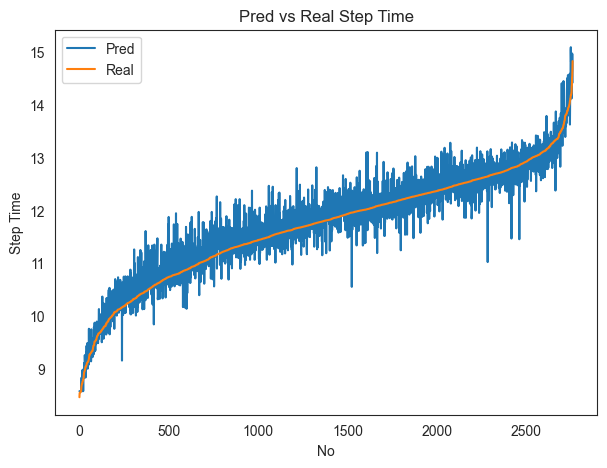

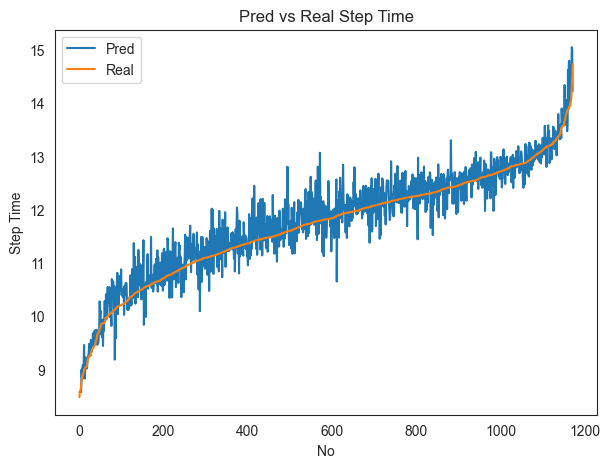

In [68]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
print("ALL RMSE:", rmse_all)
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

In [69]:
model = Sequential()
model.add(Dense(units=20, activation='relu', input_dim=5))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=1)

Epoch 1/100
2759/2759 [==============================] - 4s 1ms/step - loss: 5.0579 - val_loss: 0.5391
Epoch 2/100
2759/2759 [==============================] - 3s 1ms/step - loss: 0.3218 - val_loss: 0.1415
Epoch 3/100
2759/2759 [==============================] - 3s 1ms/step - loss: 0.1445 - val_loss: 0.1130
Epoch 4/100
2759/2759 [==============================] - 3s 1ms/step - loss: 0.1342 - val_loss: 0.0992
Epoch 5/100
2759/2759 [==============================] - 3s 1ms/step - loss: 0.1300 - val_loss: 0.1175
Epoch 6/100
2759/2759 [==============================] - 3s 1ms/step - loss: 0.1296 - val_loss: 0.0962
Epoch 7/100
2759/2759 [==============================] - 3s 1ms/step - loss: 0.1270 - val_loss: 0.0934
Epoch 8/100
2759/2759 [==============================] - 3s 1ms/step - loss: 0.1239 - val_loss: 0.2174
Epoch 9/100
2759/2759 [==============================] - 3s 1ms/step - loss: 0.1229 - val_loss: 0.1008
Epoch 10/100
2759/2759 [==============================] - 3s 1ms/step - l

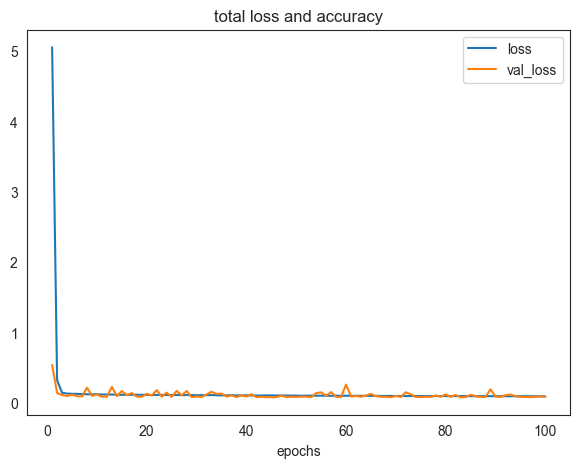

In [70]:
epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
val_loss_array = history.history['val_loss']

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, val_loss_array, label='val_loss')
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

123/123 [==============================] - 0s 795us/step
TRAIN Root Mean Squared Error(RMSE): 0.2964863583505223
TEST Root Mean Squared Error(RMSE): 0.29639263045166986
ALL RMSE: 0.296458420764437


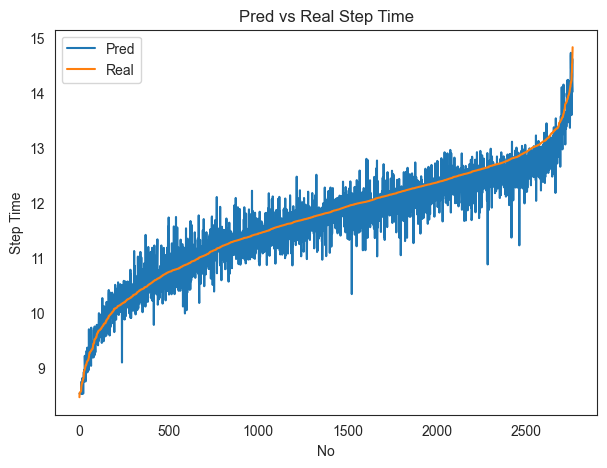

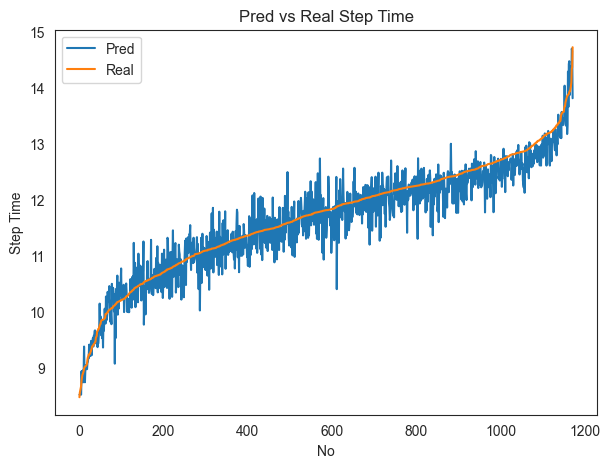

In [71]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
print("ALL RMSE:", rmse_all)
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

In [72]:
model = Sequential()
model.add(Dense(units=30, activation='relu', input_dim=5))
model.add(Dense(units=20, activation='relu', input_dim=5))
model.add(Dense(units=10, activation='relu', input_dim=5))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=1)

Epoch 1/100
2759/2759 [==============================] - 4s 1ms/step - loss: 1.6251 - val_loss: 0.8681
Epoch 2/100
2759/2759 [==============================] - 3s 1ms/step - loss: 0.2629 - val_loss: 0.1420
Epoch 3/100
2759/2759 [==============================] - 3s 1ms/step - loss: 0.2153 - val_loss: 0.1017
Epoch 4/100
2759/2759 [==============================] - 3s 1ms/step - loss: 0.1840 - val_loss: 0.0982
Epoch 5/100
2759/2759 [==============================] - 3s 1ms/step - loss: 0.1615 - val_loss: 0.1698
Epoch 6/100
2759/2759 [==============================] - 3s 1ms/step - loss: 0.1508 - val_loss: 0.5676
Epoch 7/100
2759/2759 [==============================] - 3s 1ms/step - loss: 0.1476 - val_loss: 0.0879
Epoch 8/100
2759/2759 [==============================] - 3s 1ms/step - loss: 0.1370 - val_loss: 0.0972
Epoch 9/100
2759/2759 [==============================] - 3s 1ms/step - loss: 0.1316 - val_loss: 0.2229
Epoch 10/100
2759/2759 [==============================] - 3s 1ms/step - l

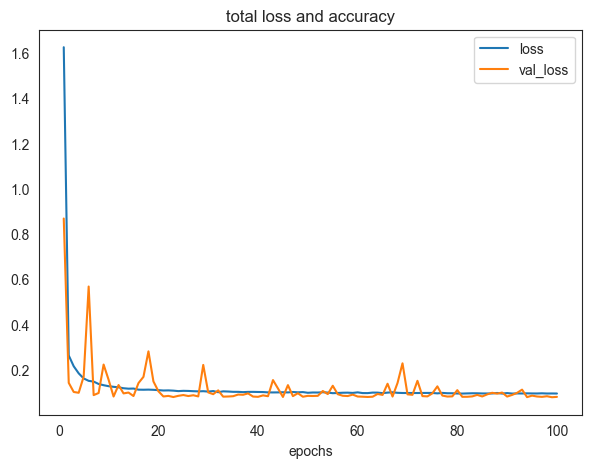

In [75]:
epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
val_loss_array = history.history['val_loss']

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, val_loss_array, label='val_loss')
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

123/123 [==============================] - 0s 775us/step
TRAIN Root Mean Squared Error(RMSE): 0.2800776247452713
TEST Root Mean Squared Error(RMSE): 0.2829715391138274
ALL RMSE: 0.28094354607628463


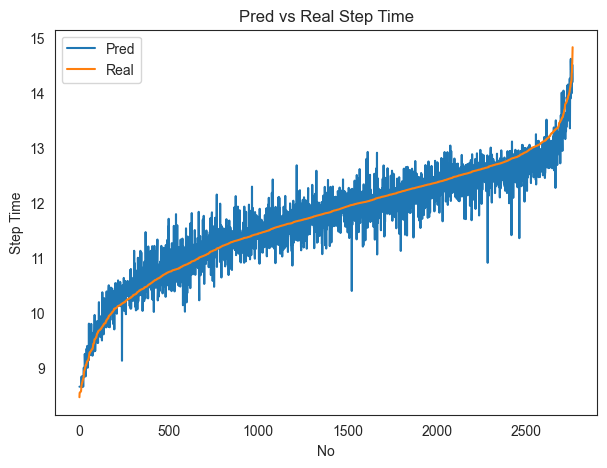

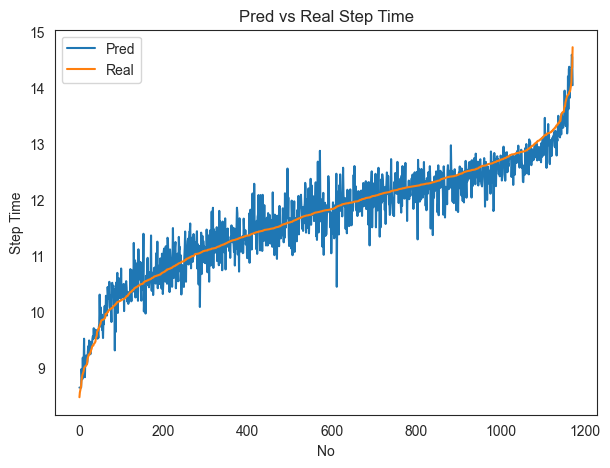

In [74]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
print("ALL RMSE:", rmse_all)
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())